In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cProfile
import pstats
import pandas as pd
from datetime import datetime
import os
import ast

In [2]:
import os
import sys

path_common=os.path.dirname(os.path.abspath(''))+"/Common/";
sys.path.append(path_common) #Adds common path to import the python files

# Tuning Resnet Based NN - Starting from resnet Similar to Quipu 

## Common code for different explorations

In [48]:
def get_csvs_ending_with(title,folder_search="../../results/ResNetTuning/Results/"):
    file_path_list=[];
    for dirpath, dnames, fnames in os.walk(folder_search):
        for f in fnames:
            if f.endswith("_"+title+".csv"):
                file_path_list.append(folder_search+f);
    return file_path_list;
def get_csvs_assuming_results_folder(csv_filename,folder_search="../../results/ResNetTuning/Results/"):
    return folder_search+csv_filename
def get_param(filepath,param,log_folder="../../results/ResNetTuning/Logs/"):
    retVal=None
    name_log=os.path.basename(filepath)[:-3]+"txt"; #Changes extension.
    with open(log_folder+name_log, 'r') as fp:
        line = fp.readline()
        while line != "": #File not finished
            if line.find(param)!= -1: #Text found
                str_2_convert=line[len(param)+2:]
                if param=="activation":
                    retVal=str_2_convert; #We want the string!
                else:
                    retVal= 0 if ("None" in str_2_convert) else float(str_2_convert)
                break;
            line = fp.readline()
    return retVal;

## LR tuning

In [30]:
def get_values_plot(df):
    n=len(df);
    keys=["Train Losses","Train Aug Losses","Valid Losses"];
    means=[];stds=[];
    for key in keys:
        list_of_numpy_arrays=[]; lengths=np.zeros((n,),dtype=int);
        for i in range(n): #For each row
            string_results=df[key][i]; ##String that has the whole array of losses
            list_of_numpy_arrays.append(np.asarray(ast.literal_eval(string_results.replace(" ", ","))))
            lengths[i]=len(list_of_numpy_arrays[-1]);
        len_out=np.max(lengths)
        aux_means=[];aux_stds=[];
        for i in range(len_out):
            run_idxs_to_consider=np.argwhere(i<lengths)[:,0]
            aux_vect=[];
            for run_idx in run_idxs_to_consider:
                aux_vect.append(list_of_numpy_arrays[run_idx][i]);
            aux_means.append(np.mean(aux_vect))
            aux_stds.append(np.std(aux_vect));
        means.append(np.asarray(aux_means));
        stds.append(np.asarray(aux_stds));
    l_train_mean=means[0];l_train_stds=stds[0];
    l_train_aug_mean=means[1];l_train_aug_stds=stds[1];
    l_valid_mean=means[2];l_valid_stds=stds[2];
    return l_train_mean,l_train_stds,l_train_aug_mean,l_train_aug_stds,l_valid_mean,l_valid_stds
def print_accuracies_df(df):
    all_accs=df.iloc[:,:3].values;
    all_means=np.mean(all_accs,axis=0)
    all_stds=np.std(all_accs,axis=0)
    print("Train Acc: " + "{:.2f}".format(all_means[0]*100) + " +- " + "{:.2f}".format(all_stds[0]*100) + " % ")
    print("Valid Acc: " + "{:.2f}".format(all_means[1]*100) + " +- " + "{:.2f}".format(all_stds[1]*100) + " % ")
    print("Test Acc: " + "{:.2f}".format(all_means[2]*100) + " +- " + "{:.2f}".format(all_stds[2]*100) + " % ")
    n_samples=np.shape(all_accs)[0];
    median_test=np.median(all_accs[:,-1]);
    print("Test Accuracy estimator: " + "{:.2f}".format(all_means[2]*100) + " +- " + "{:.2f}".format(all_stds[2]*100/np.sqrt(n_samples)) + " % . Median:" + "{:.2f}".format(median_test*100))

def compare_params(file_ending,param_str,curve_to_plot="AugTrain",add_base_param=None):
    csvs_paths=get_csvs_ending_with(file_ending)
    if not(add_base_param is None):
        csvs_paths.append(get_csvs_assuming_results_folder(add_base_param))
    params=[get_param(i,param_str) for i in csvs_paths]
    n_experiments=len(params)
    idxs_sorted=np.argsort(params)
    csvs_paths_ordered=[csvs_paths[i] for i in idxs_sorted]
    params=np.sort(params)
    plt.figure(figsize=(20,10));
    all_colors=["b","g","r","c","m","y"];
    colors=all_colors[:n_experiments]; #Keeps the colors that we need to plot 
    handles_legend=[];
    for i in range(n_experiments):
        df=pd.read_csv(csvs_paths_ordered[i]);
        l_train_mean,l_train_stds,l_train_aug_mean,l_train_aug_stds,l_valid_mean,l_valid_stds=get_values_plot(df);
        print(param_str+": " + str(params[i]))
        print_accuracies_df(df)
        x=np.arange(len(l_train_mean));
        if curve_to_plot=="AugTrain":
            plt.errorbar(x, l_train_aug_mean, yerr=l_train_aug_stds,color=colors[i],linestyle="-");
            plt.title("Loss on augmented train dataset");
        elif curve_to_plot=="Train":
            plt.errorbar(x, l_train_mean, yerr=l_train_stds,color=colors[i],linestyle="-");
            plt.title("Loss on train dataset");
        else:
            plt.errorbar(x, l_valid_mean, yerr=l_valid_stds,color=colors[i],linestyle="-");
            plt.title("Loss on validation dataset");
        handles_legend.append(mlines.Line2D([], [], color=colors[i], label=str(params[i])))
    
    # etc etc
    plt.legend(handles=handles_legend)
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.ylim([0,1])
    plt.show()

Learning rate: 5e-05
Train Acc: 96.81 +- 0.37 % 
Valid Acc: 95.75 +- 0.29 % 
Test Acc: 91.76 +- 1.86 % 
Test Accuracy estimator: 91.76 +- 0.42 % . Median:91.70
Learning rate: 0.0001
Train Acc: 96.93 +- 0.36 % 
Valid Acc: 95.79 +- 0.27 % 
Test Acc: 92.04 +- 2.13 % 
Test Accuracy estimator: 92.04 +- 0.48 % . Median:92.62
Learning rate: 0.0005
Train Acc: 96.56 +- 0.59 % 
Valid Acc: 95.68 +- 0.39 % 
Test Acc: 92.28 +- 2.25 % 
Test Accuracy estimator: 92.28 +- 0.50 % . Median:92.70
Learning rate: 0.001
Train Acc: 96.32 +- 0.54 % 
Valid Acc: 95.45 +- 0.52 % 
Test Acc: 91.33 +- 1.85 % 
Test Accuracy estimator: 91.33 +- 0.41 % . Median:91.33


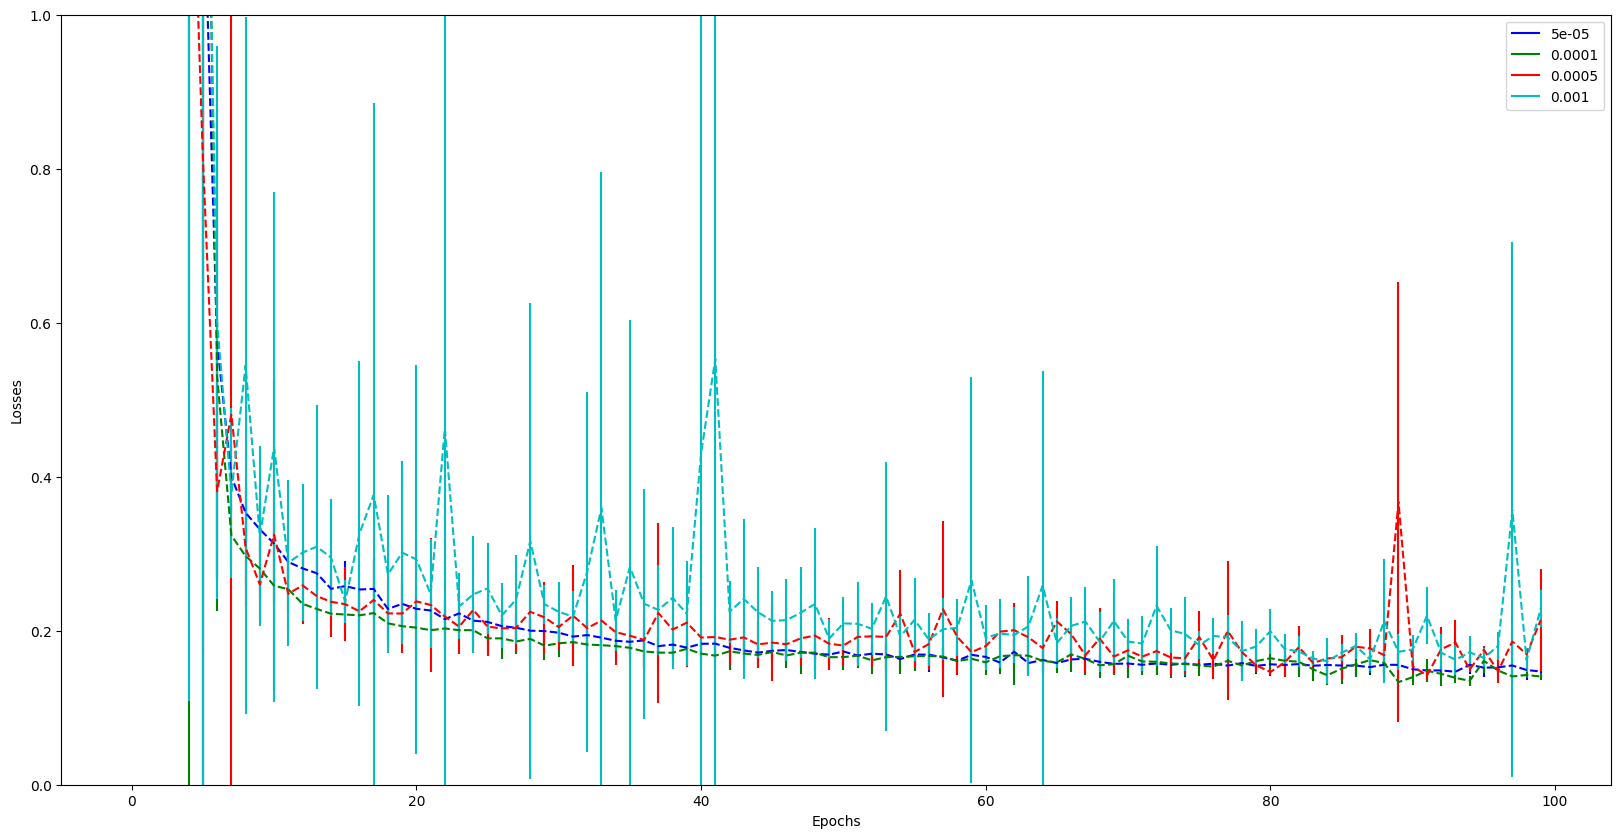

In [107]:
csvs_paths=get_csvs_ending_with("LR")
lrs=[get_param(i,"lr") for i in csvs_paths]
n_experiments=len(lrs)
idxs_sorted=np.argsort(lrs)
csvs_paths_ordered=[csvs_paths[i] for i in idxs_sorted]
lrs=np.sort(lrs)
plt.figure(figsize=(20,10));
all_colors=["b","g","r","c","m","y"];
colors=all_colors[:n_experiments]; #Keeps the colors that we need to plot 
handles_legend=[];
for i in range(n_experiments):
    df=pd.read_csv(csvs_paths_ordered[i]);
    l_train_mean,l_train_stds,l_train_aug_mean,l_train_aug_stds,l_valid_mean,l_valid_stds=get_values_plot(df);
    print("Learning rate: " + str(lrs[i]))
    print_accuracies_df(df)
    x=np.arange(len(l_train_mean));
    #plt.errorbar(x, l_train_mean, yerr=l_train_stds,color=colors[i],linestyle="-.");
    #plt.errorbar(x, l_train_aug_mean, yerr=l_train_aug_stds,color=colors[i],linestyle="-");
    plt.errorbar(x, l_valid_mean, yerr=l_valid_stds,color=colors[i],linestyle="--");
    handles_legend.append(mlines.Line2D([], [], color=colors[i], label=str(lrs[i])))

# etc etc
plt.legend(handles=handles_legend)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.ylim([0,1])
plt.show()

## Search for minibatch

batch size: 32.0
Train Acc: 97.18 +- 0.38 % 
Valid Acc: 96.06 +- 0.34 % 
Test Acc: 90.30 +- 2.76 % 
Test Accuracy estimator: 90.30 +- 0.87 % . Median:90.82
batch size: 64.0
Train Acc: 97.33 +- 0.43 % 
Valid Acc: 96.02 +- 0.32 % 
Test Acc: 92.41 +- 1.62 % 
Test Accuracy estimator: 92.41 +- 0.51 % . Median:92.58
batch size: 128.0
Train Acc: 96.89 +- 0.47 % 
Valid Acc: 95.83 +- 0.28 % 
Test Acc: 91.45 +- 1.50 % 
Test Accuracy estimator: 91.45 +- 0.47 % . Median:91.60
batch size: 256.0
Train Acc: 97.16 +- 0.62 % 
Valid Acc: 95.83 +- 0.46 % 
Test Acc: 93.74 +- 1.22 % 
Test Accuracy estimator: 93.74 +- 0.39 % . Median:93.19


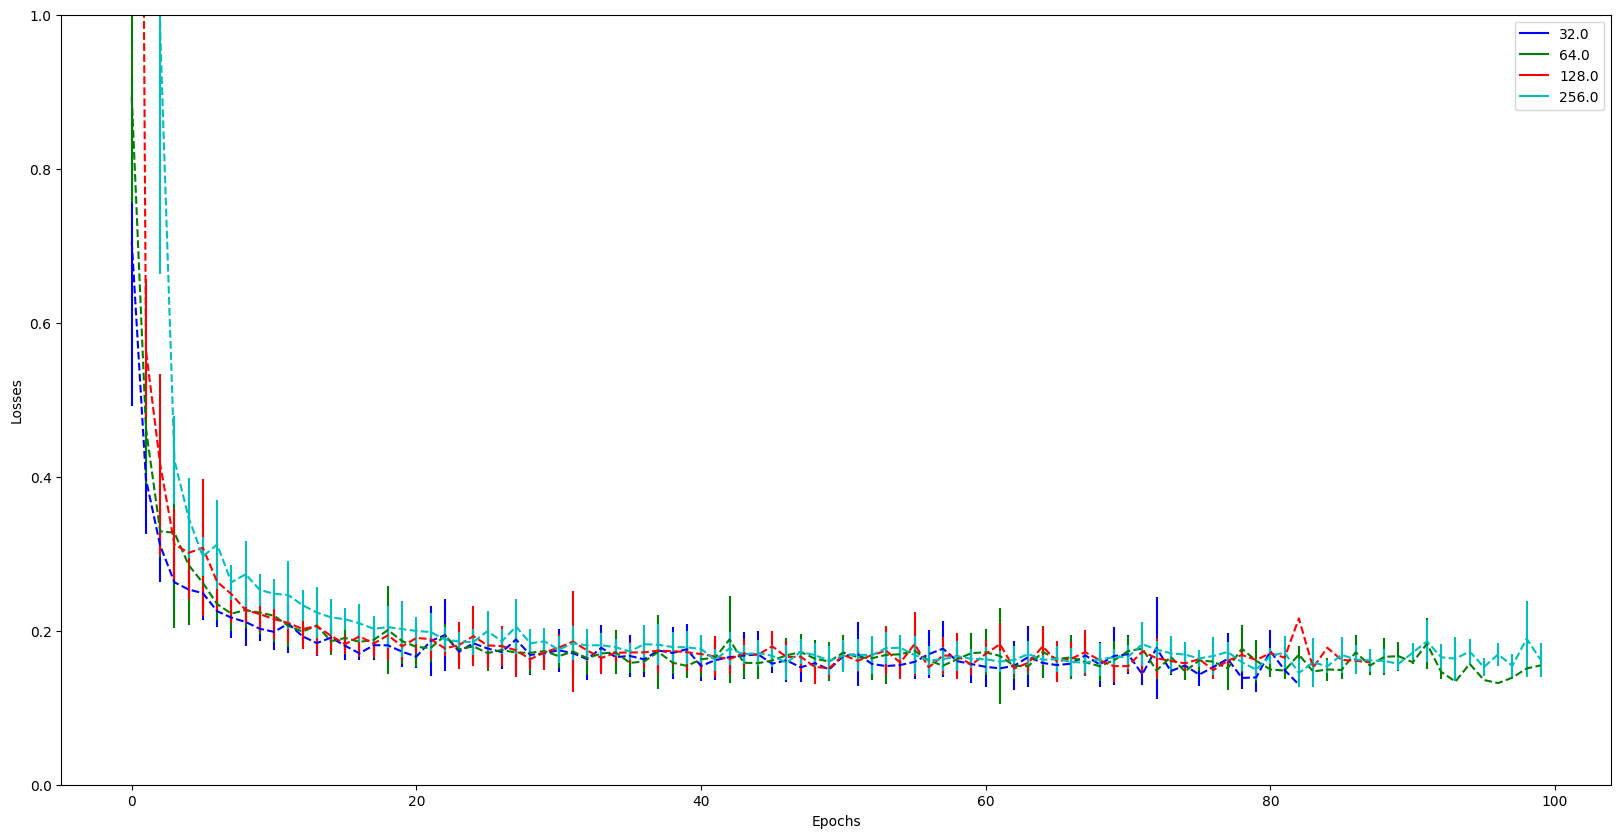

In [118]:
csvs_paths=get_csvs_ending_with("BS")
bs=[get_param(i,"batch_size") for i in csvs_paths]
n_experiments=len(bs)
idxs_sorted=np.argsort(bs)
csvs_paths_ordered=[csvs_paths[i] for i in idxs_sorted]
bs=np.sort(bs)
plt.figure(figsize=(20,10));
all_colors=["b","g","r","c","m","y"];
colors=all_colors[:n_experiments]; #Keeps the colors that we need to plot 
handles_legend=[];
for i in range(n_experiments):
    df=pd.read_csv(csvs_paths_ordered[i]);
    l_train_mean,l_train_stds,l_train_aug_mean,l_train_aug_stds,l_valid_mean,l_valid_stds=get_values_plot(df);
    print("batch size: " + str(bs[i]))
    print_accuracies_df(df)
    x=np.arange(len(l_train_mean));
    #plt.errorbar(x, l_train_mean, yerr=l_train_stds,color=colors[i],linestyle="-.");
    #plt.errorbar(x, l_train_aug_mean, yerr=l_train_aug_stds,color=colors[i],linestyle="-");
    plt.errorbar(x, l_valid_mean, yerr=l_valid_stds,color=colors[i],linestyle="--");
    handles_legend.append(mlines.Line2D([], [], color=colors[i], label=str(bs[i])))

# etc etc
plt.legend(handles=handles_legend)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.ylim([0,1])
plt.show()

## Review of parameters of augmentation

After manual inspection of augmented traces seems like resizing doesnt make aliases in most of the samples, but we observed that the noise levels were to high. So the first parameter to check if it helps would be the noise level.

### Noise level
Here I realized there was a bug in the filling of noise at the end of augmented samples. After fixing it I realized that the training was being very noisy, so decided to lower the LR from the optimal value

filter_sizes: 100
Train Acc: 97.12 +- 0.56 % 
Valid Acc: 96.06 +- 0.48 % 
Test Acc: 92.13 +- 1.20 % 
Test Accuracy estimator: 92.13 +- 0.27 % . Median:92.16
filter_sizes: 128
Train Acc: 96.86 +- 0.55 % 
Valid Acc: 95.72 +- 0.44 % 
Test Acc: 92.59 +- 2.09 % 
Test Accuracy estimator: 92.59 +- 0.47 % . Median:92.78


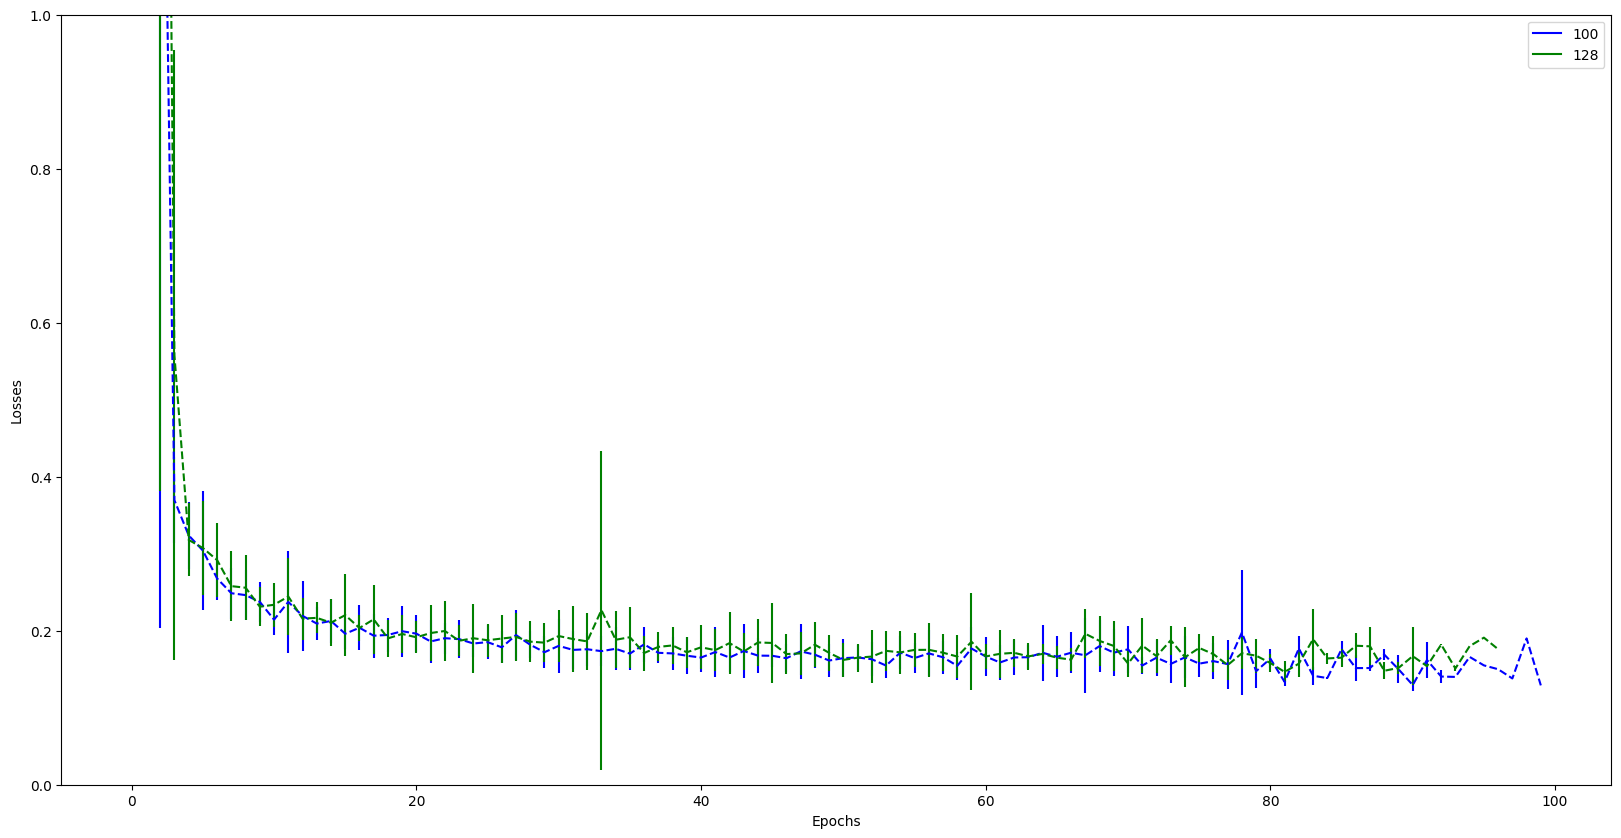

In [147]:
csvs_paths=get_csvs_ending_with("Resnet_Filter")
filter_sizes=[100, 128] ## Log didnt include the parameter easily to extract
n_experiments=len(filter_sizes)
idxs_sorted=np.argsort(filter_sizes)
csvs_paths_ordered=[csvs_paths[i] for i in idxs_sorted]
filter_sizes=np.sort(filter_sizes)
plt.figure(figsize=(20,10));
all_colors=["b","g","r","c","m","y"];
colors=all_colors[:n_experiments]; #Keeps the colors that we need to plot 
handles_legend=[];
for i in range(n_experiments):
    df=pd.read_csv(csvs_paths_ordered[i]);
    l_train_mean,l_train_stds,l_train_aug_mean,l_train_aug_stds,l_valid_mean,l_valid_stds=get_values_plot(df);
    print("filter_sizes: " + str(filter_sizes[i]))
    print_accuracies_df(df)
    x=np.arange(len(l_train_mean));
    #plt.errorbar(x, l_train_mean, yerr=l_train_stds,color=colors[i],linestyle="-.");
    #plt.errorbar(x, l_train_aug_mean, yerr=l_train_aug_stds,color=colors[i],linestyle="-");
    plt.errorbar(x, l_valid_mean, yerr=l_valid_stds,color=colors[i],linestyle="--");
    handles_legend.append(mlines.Line2D([], [], color=colors[i], label=str(filter_sizes[i])))

# etc etc
plt.legend(handles=handles_legend)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.ylim([0,1])
plt.show()

# Restarting with new structure

It happened that for the different augmentations the training was not reaching a high accuracy as it should get. Then we restart. First we try with a resnet to fit the data ONLY AUGMENTING WITH A BIT OF NOISE. 

Then High accuracies on train can be achieved but the model fails to generalize:

In [17]:
df=pd.read_csv("../../results/ResNetTuning/Results/20231018_11-22-12_NoAug.csv");
print_accuracies_df(df)

Train Acc: 99.33 +- 0.62 % 
Valid Acc: 94.78 +- 0.38 % 
Test Acc: 84.50 +- 5.13 % 
Test Accuracy estimator: 84.50 +- 1.15 % . Median:85.89


Then we now run with the augmenting parameters from quipu but a much bigger network that achieves high training accuracy:

Learning rate: 0.0001
Train Acc: 96.09 +- 0.29 % 
Valid Acc: 95.48 +- 0.32 % 
Test Acc: 89.49 +- 2.73 % 
Test Accuracy estimator: 89.49 +- 0.61 % . Median:89.60
Learning rate: 0.0004
Train Acc: 96.58 +- 0.39 % 
Valid Acc: 95.83 +- 0.38 % 
Test Acc: 90.51 +- 2.36 % 
Test Accuracy estimator: 90.51 +- 0.33 % . Median:90.59
Learning rate: 0.0008
Train Acc: 96.33 +- 0.40 % 
Valid Acc: 95.55 +- 0.38 % 
Test Acc: 90.62 +- 2.37 % 
Test Accuracy estimator: 90.62 +- 0.53 % . Median:90.72


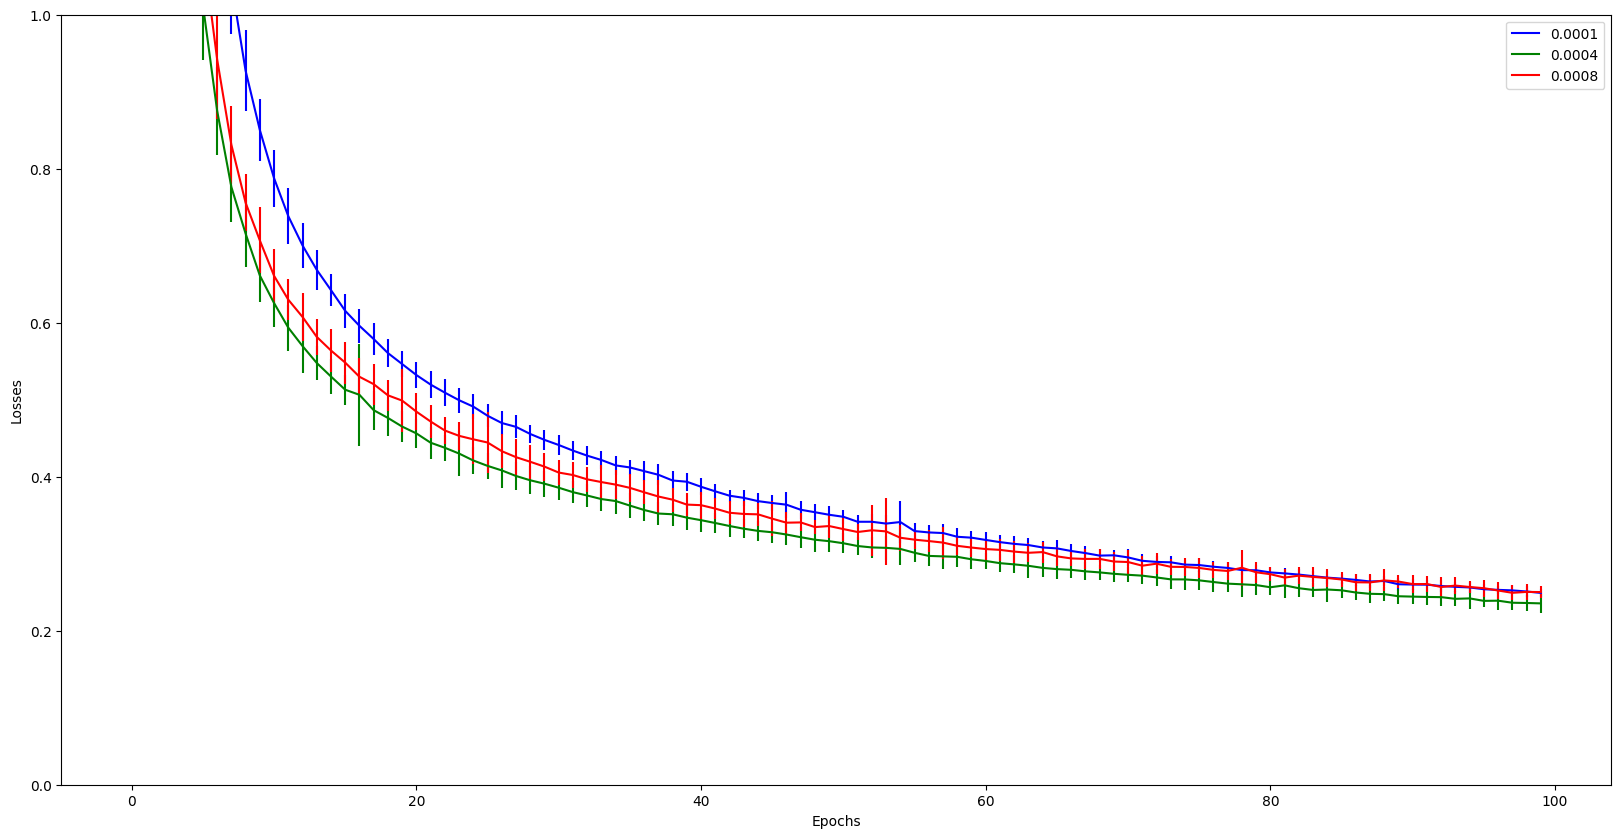

In [20]:
csvs_paths=get_csvs_ending_with("RepQuipu")
lrs=[get_param(i,"lr") for i in csvs_paths]
n_experiments=len(lrs)
idxs_sorted=np.argsort(lrs)
csvs_paths_ordered=[csvs_paths[i] for i in idxs_sorted]
lrs=np.sort(lrs)
plt.figure(figsize=(20,10));
all_colors=["b","g","r","c","m","y"];
colors=all_colors[:n_experiments]; #Keeps the colors that we need to plot 
handles_legend=[];
for i in range(n_experiments):
    df=pd.read_csv(csvs_paths_ordered[i]);
    l_train_mean,l_train_stds,l_train_aug_mean,l_train_aug_stds,l_valid_mean,l_valid_stds=get_values_plot(df);
    print("Learning rate: " + str(lrs[i]))
    print_accuracies_df(df)
    x=np.arange(len(l_train_mean));
    #plt.errorbar(x, l_train_mean, yerr=l_train_stds,color=colors[i],linestyle="-.");
    plt.errorbar(x, l_train_aug_mean, yerr=l_train_aug_stds,color=colors[i],linestyle="-");
    #plt.errorbar(x, l_valid_mean, yerr=l_valid_stds,color=colors[i],linestyle="--");
    handles_legend.append(mlines.Line2D([], [], color=colors[i], label=str(lrs[i])))

# etc etc
plt.legend(handles=handles_legend)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.ylim([0,1])
plt.show()

# Revisiting augmentation parameters

After doubting of the hyperparameters of the augmentation done in Quipu a manual inspection is carried out to analyze these parameters

In [21]:
from DatasetFuncs import load_unfolded_df,show_partition_nanopores #We load the unfolded dataframe
df_unfolded=load_unfolded_df()

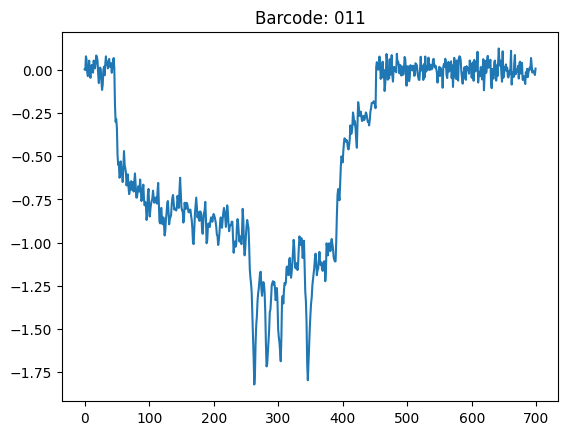

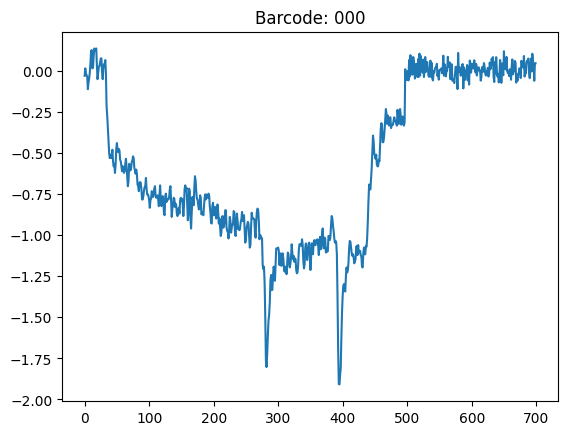

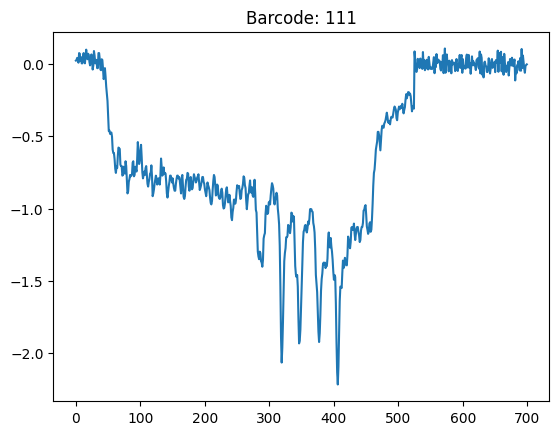

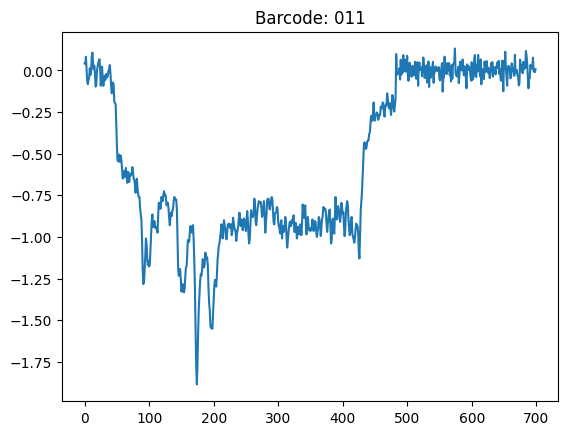

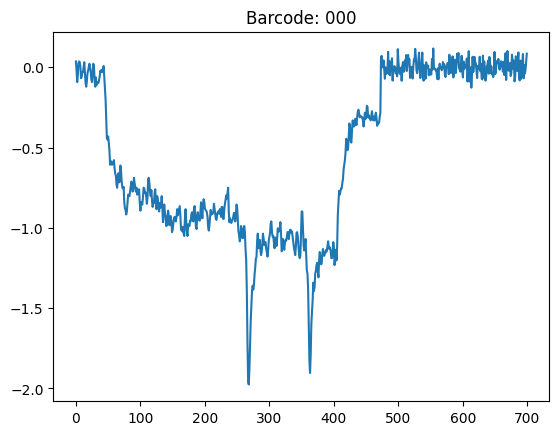

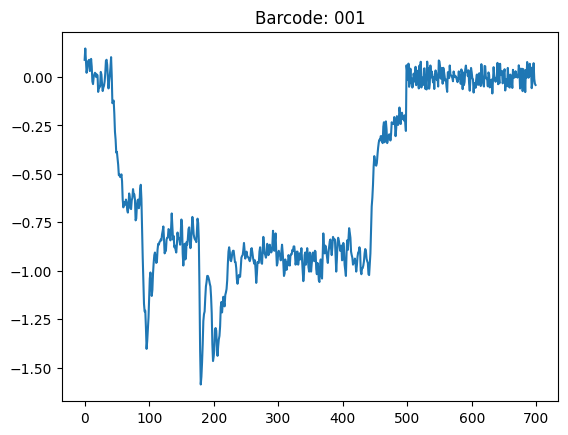

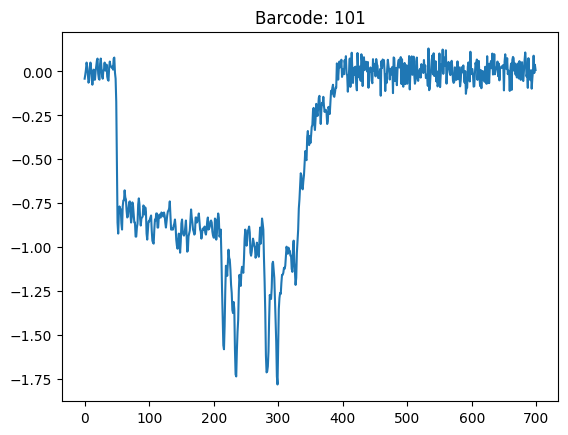

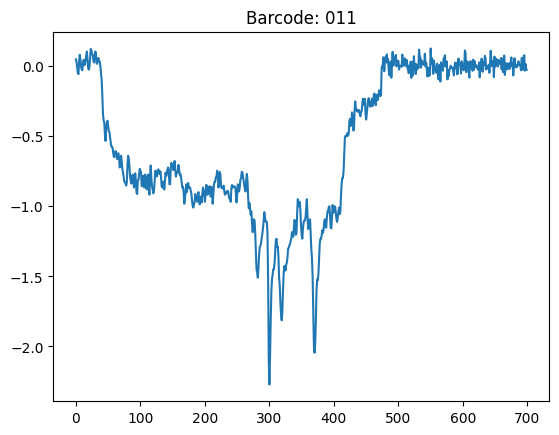

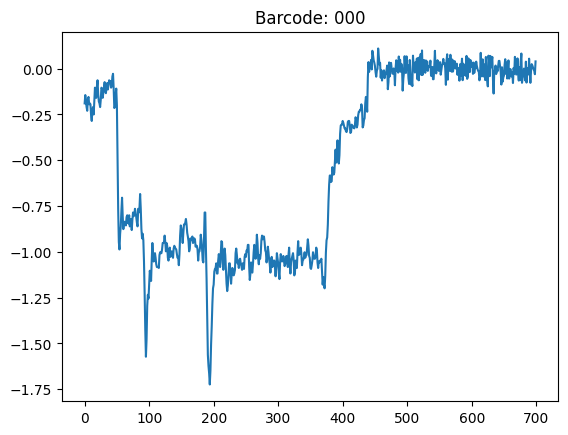

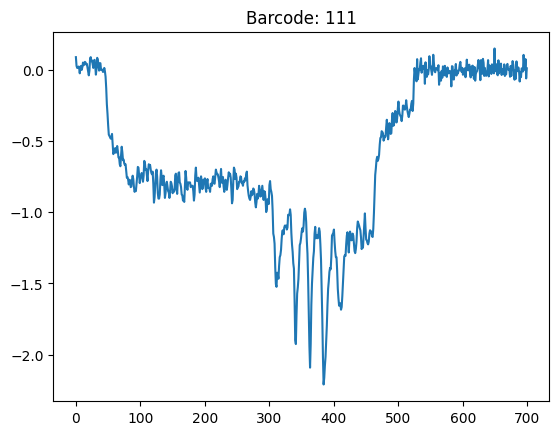

In [5]:
n_plot=10;
np.random.seed(1);
idxs_plot=np.random.randint(len(df_unfolded), size=10);
for i in range(n_plot):
    idx=idxs_plot[i]
    plt.plot(df_unfolded.iloc[idx][2])
    str_title= "Barcode: " + str(df_unfolded.iloc[idx,0]);
    plt.title(str_title)
    plt.show()

Even when considering only unfolded events, the traces behave very differently and it is hard to map how is the population of magnitude and stretch (which are the parameters for augmentation. For example, in some traces the baseline seems to decrease with time while in others remains similar. 

Therefore, lets do an analysis on the simples barcode (000, because it should be the one that has less impact on baseline) for only the same nanopore. There we can study how the magnitude and stretch is distributed

In [22]:
show_partition_nanopores(df_unfolded)

barcode  nanopore  size
0      000         6    45
1      000         7   348
2      000         8   576
3      001         7   173
4      001         8   284
5      010         7   196
6      010         9   105
7      010        10   152
8      011         6   279
9      011         7   147
10     011        11    72
11     011        12   112
12     100         7    56
13     100        13   115
14     101         8   232
15     110         7   223
16     110         8   557
17     110        12   118
18     110        13   252
19     110        14   310
20     111         7   176
21     111         8   575
22     111         9   174
23     111        14   165
24     111        15   238

Then we analyze the barcodes 000 of the nanopore 8 because we have a big population

In [30]:
df_unfolded_000_n8=df_unfolded[ (df_unfolded["barcode"]=="000") & (df_unfolded["nanopore"]==8)]
df_unfolded_000_n8

barcode  nanopore                                              trace  \
363      000         8  [0.028548488283176323, 0.0992080549712768, 0.1...   
368      000         8  [0.05853315082003692, 0.11909529348811693, 0.1...   
379      000         8  [0.034069373129716946, 0.08958811672102367, 0....   
387      000         8  [-0.025384827438267855, 0.014996088963865145, ...   
392      000         8  [-0.01741874830143012, 0.0633329703634547, 0.1...   
...      ...       ...                                                ...   
5051     000         8  [0.04281927955857038, 0.042819388475315245, 0....   
5053     000         8  [-0.005437215681641632, -0.0003905543904646797...   
5072     000         8  [-0.036784783707538744, -0.04183218136803331, ...   
5083     000         8  [-0.03892829560528977, -0.07425850831901297, -...   
5093     000         8  [-0.007336078455341721, 0.012851647206895897, ...   

      Filter  nbell_quality  nbell_barcode  nbell_positive_barcode  Bound  \
363     True           True            0.0                     0.0  False   
368     True           True            0.0                     0.0  False   
379     True           True            0.0                     0.0  False   
387     True           True            0.0                     0.0  False   
392     True           True            0.0                     0.0  False   
...      ...            ...            ...                     ...    ...   
5051    True           True            0.0                     1.0  False   
5053    True           True            0.0                     0.0  False   
5072    True           True            0.0                     0.0  False   
5083    True           True            0.0                     0.0  False   
5093    True           True            0.0                     0.0  False   

           Area  UnfoldedLevel human_barcode  
363   48.539684      -0.127568                
368   49.186628      -0.127568                
379   47.194026      -0.127568                
387   48.688443      -0.127568                
392   48.028222      -0.127568                
...         ...            ...           ...  
5051  46.343744      -0.127568                
5053  45.156237      -0.127568                
5072  48.180855      -0.127568                
5083  50.899060      -0.127568                
5093  48.168041      -0.127568                

[576 rows x 11 columns]

In [49]:
def analyze_trace(trace,ev_start_th=-0.25,ev_end_th=-0.5):
    id_start=np.argwhere(trace<ev_start_th)[0,0];
    id_end=np.argwhere(trace<ev_end_th)[-1,0];
    ev_len=id_end-id_start;
    med=np.median(trace[id_start:id_end])
    return id_start,id_end,ev_len,med

def analyze_df(df):
    lengths=[];
    medians=[];
    idx_trace=np.argwhere(df_unfolded_000_n8.columns=="trace")[0,0]
    for i in range(len(df)):
        trace=df.iloc[i,idx_trace]
        id_start,id_end,ev_len,med=analyze_trace(trace)
        lengths.append(ev_len)
        medians.append(med)
    return lengths,medians
    

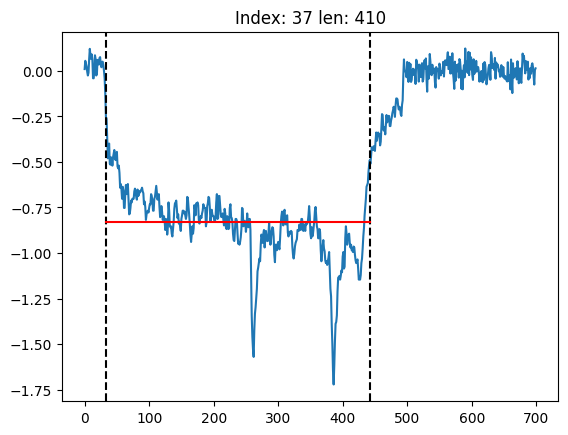

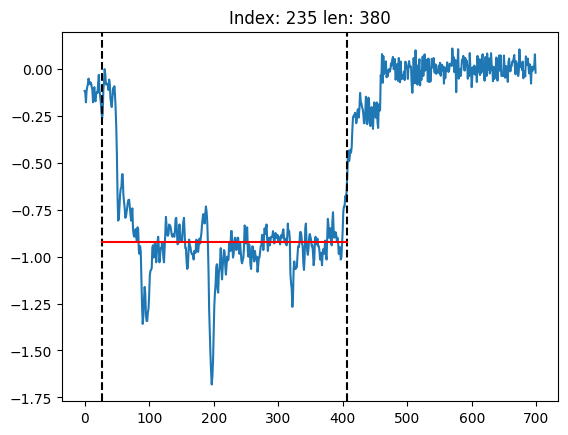

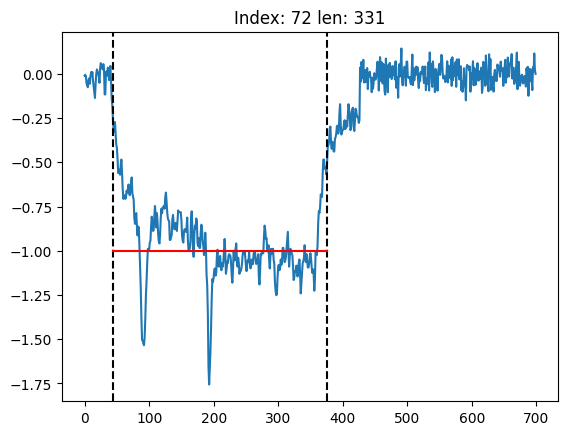

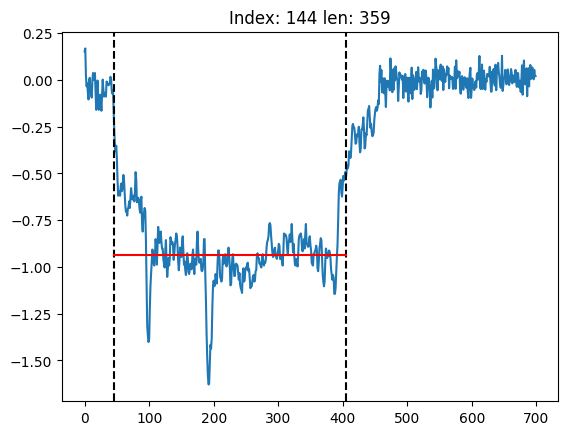

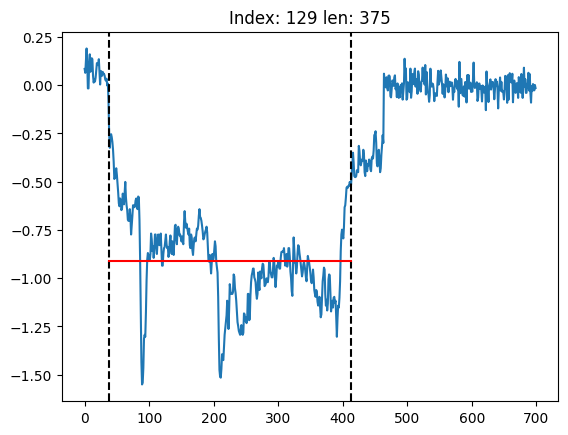

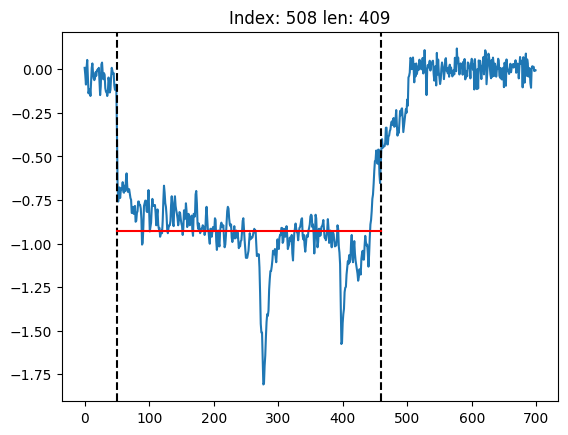

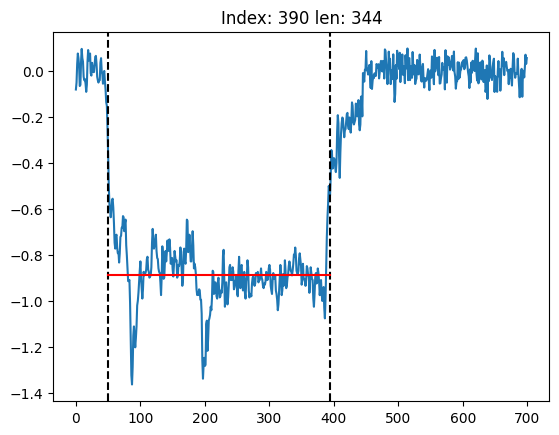

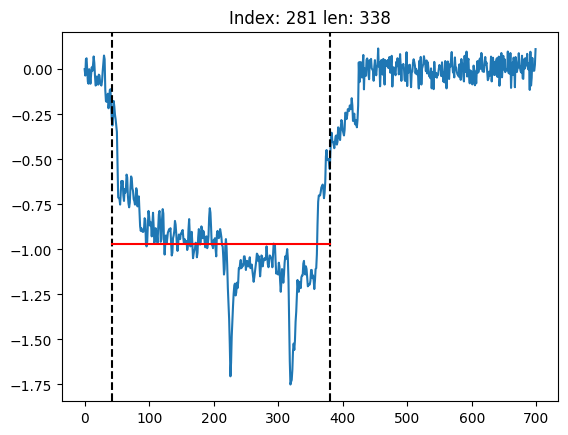

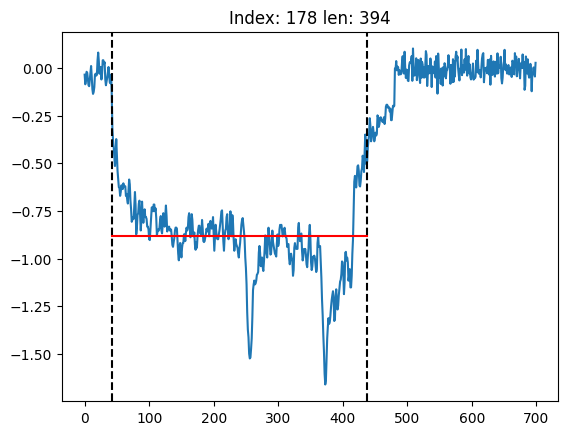

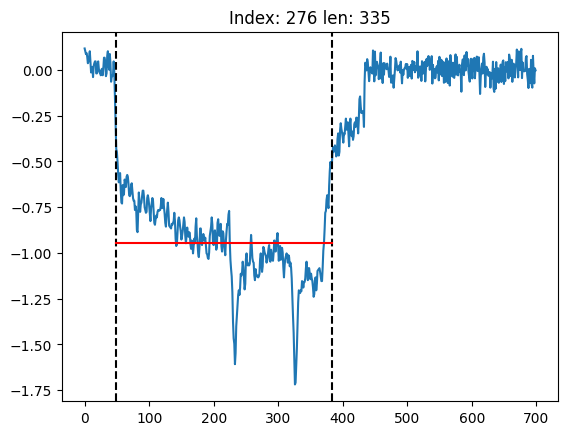

In [38]:
n_plot=10;
np.random.seed(1);
idxs_plot=np.random.randint(len(df_unfolded_000_n8), size=n_plot);
for i in range(n_plot):
    idx=idxs_plot[i]
    ev_data=df_unfolded_000_n8.iloc[idx][2]
    id_start,id_end,ev_len,med=analyze_trace(ev_data)
    plt.plot(ev_data,label="Original trace")
    plt.axvline(x = id_start, color = 'black', linestyle="--")
    plt.axvline(x = id_end, color = 'black', linestyle="--")
    plt.plot([id_start,id_end], [med,med],label="Median",color = 'r')
    str_title= "Index: " + str(idx) + " len: "+ str(ev_len);
    plt.title(str_title)
    plt.show()

In [56]:
lengths,medians=analyze_df(df_unfolded_000_n8)
print("The lengths have a mean of "+str(np.mean(lengths)) + " and a std of " + str(np.std(lengths)))
print("This means a normalized scaling factor of " + str(np.std(lengths)/np.mean(lengths)))
print("The medians have a mean of "+str(np.mean(medians)) + " and a std of " + str(np.std(medians)))
print("This means a normalized magnitude factor of " + str(np.abs(np.std(medians)/np.mean(medians))))

The lengths have a mean of 363.5 and a std of 31.325409015685654
This means a normalized scaling factor of 0.08617719123985049
The medians have a mean of -0.9113348490719283 and a std of 0.05115007779224113
This means a normalized magnitude factor of 0.05612654650958491


In [55]:
print("NOW USING THE WHOLE UNFOLDED DATASET")
lengths,medians=analyze_df(df_unfolded)
print("The lengths have a mean of "+str(np.mean(lengths)) + " and a std of " + str(np.std(lengths)))
print("This means a normalized scaling factor of " + str(np.abs(np.std(lengths)/np.mean(lengths))))
print("The medians have a mean of "+str(np.mean(medians)) + " and a std of " + str(np.std(medians)))
print("This means a normalized magnitude factor of " + str(np.abs(np.std(medians)/np.mean(medians))))

NOW USING THE WHOLE UNFOLDED DATASET
The lengths have a mean of 362.4142605633803 and a std of 51.44486013844825
This means a normalized scaling factor of 0.14195043003682076
The medians have a mean of -0.9173683732049541 and a std of 0.05968876772778143
This means a normalized magnitude factor of 0.06506521204698873


The first thing to conclude is that the std of the median is bigger because of some samples having this discharge at the beginning. Even though that happens, the estimated std is 0.06, which shows lower. Lets compare experiment-wise:

In [63]:
labels = np.array(['000', '001', '010', '011', '100', '101', '110', '111'])
columns=["Label", "Nanopore", "Mean length", "Norm length std","Mean median", "Norm median std","samples"]
df_list=[];#List keeping all rows for the df
for label in labels:
    label_nanopore_ids=np.unique(df_unfolded[df_unfolded["barcode"]==label]["nanopore"]) 
    for nanopore_id in label_nanopore_ids:
        df_experiment=df_unfolded[ (df_unfolded["barcode"]==label) & (df_unfolded["nanopore"]==nanopore_id)]
        exp_samples=len(df_experiment);
        lengths,medians=analyze_df(df_experiment)
        mean_len=np.mean(lengths);mean_median=np.mean(medians);
        norm_len_std=np.std(lengths)/mean_len;
        norm_med_std=np.abs(np.std(medians)/mean_median);
        df_list.append([label,nanopore_id,mean_len,norm_len_std,mean_median,norm_med_std,exp_samples])
df_results=pd.DataFrame(df_list,columns=columns)

In [64]:
df_results

Label  Nanopore  Mean length  Norm length std  Mean median  \
0    000         6   393.244444         0.089235    -0.933116   
1    000         7   380.247126         0.091380    -0.920290   
2    000         8   363.500000         0.086177    -0.911335   
3    001         7   366.526012         0.061393    -0.902824   
4    001         8   423.369718         0.070434    -0.906065   
5    010         7   348.204082         0.072823    -0.908517   
6    010         9   329.561905         0.066263    -0.908361   
7    010        10   369.993421         0.059741    -0.906895   
8    011         6   380.641577         0.107509    -0.917579   
9    011         7   309.081633         0.065185    -0.918992   
10   011        11   371.194444         0.071422    -0.907391   
11   011        12   353.589286         0.085915    -0.910960   
12   100         7   354.732143         0.064527    -0.926726   
13   100        13   353.200000         0.088928    -0.927729   
14   101         8   276.788793         0.075788    -0.928399   
15   110         7   320.650224         0.073346    -0.927171   
16   110         8   326.684022         0.084398    -0.926049   
17   110        12   376.423729         0.086914    -0.921064   
18   110        13   361.845238         0.075782    -0.924633   
19   110        14   295.154839         0.079717    -0.928950   
20   111         7   414.176136         0.084750    -0.921984   
21   111         8   361.394783         0.084138    -0.915353   
22   111         9   446.517241         0.081397    -0.915381   
23   111        14   424.175758         0.074763    -0.906612   
24   111        15   440.205882         0.091458    -0.909813   

    Norm median std  samples  
0          0.043077       45  
1          0.062865      348  
2          0.056127      576  
3          0.053245      173  
4          0.067530      284  
5          0.060595      196  
6          0.056563      105  
7          0.049059      152  
8          0.067831      279  
9          0.063657      147  
10         0.055800       72  
11         0.058595      112  
12         0.062124       56  
13         0.050115      115  
14         0.057478      232  
15         0.055994      223  
16         0.067924      557  
17         0.061232      118  
18         0.076016      252  
19         0.062892      310  
20         0.069482      176  
21         0.075912      575  
22         0.067058      174  
23         0.059925      165  
24         0.077541      238

Here we can see that there is much variation within mean lengths between each experiment. The std is around 0.08 for most experiments, but it grows bigger if we put all the samples together. 

lr: 1e-05
Train Acc: 97.06 +- 0.90 % 
Valid Acc: 95.66 +- 0.68 % 
Test Acc: 90.21 +- 4.99 % 
Test Accuracy estimator: 90.21 +- 1.12 % . Median:91.55
lr: 5e-05
Train Acc: 96.91 +- 1.24 % 
Valid Acc: 95.71 +- 0.91 % 
Test Acc: 90.33 +- 3.41 % 
Test Accuracy estimator: 90.33 +- 0.76 % . Median:89.90
lr: 0.0001
Train Acc: 96.82 +- 0.86 % 
Valid Acc: 95.63 +- 0.77 % 
Test Acc: 89.41 +- 4.76 % 
Test Accuracy estimator: 89.41 +- 1.06 % . Median:90.67
lr: 0.0005
Train Acc: 95.83 +- 1.46 % 
Valid Acc: 94.90 +- 1.24 % 
Test Acc: 89.34 +- 3.67 % 
Test Accuracy estimator: 89.34 +- 0.82 % . Median:90.28


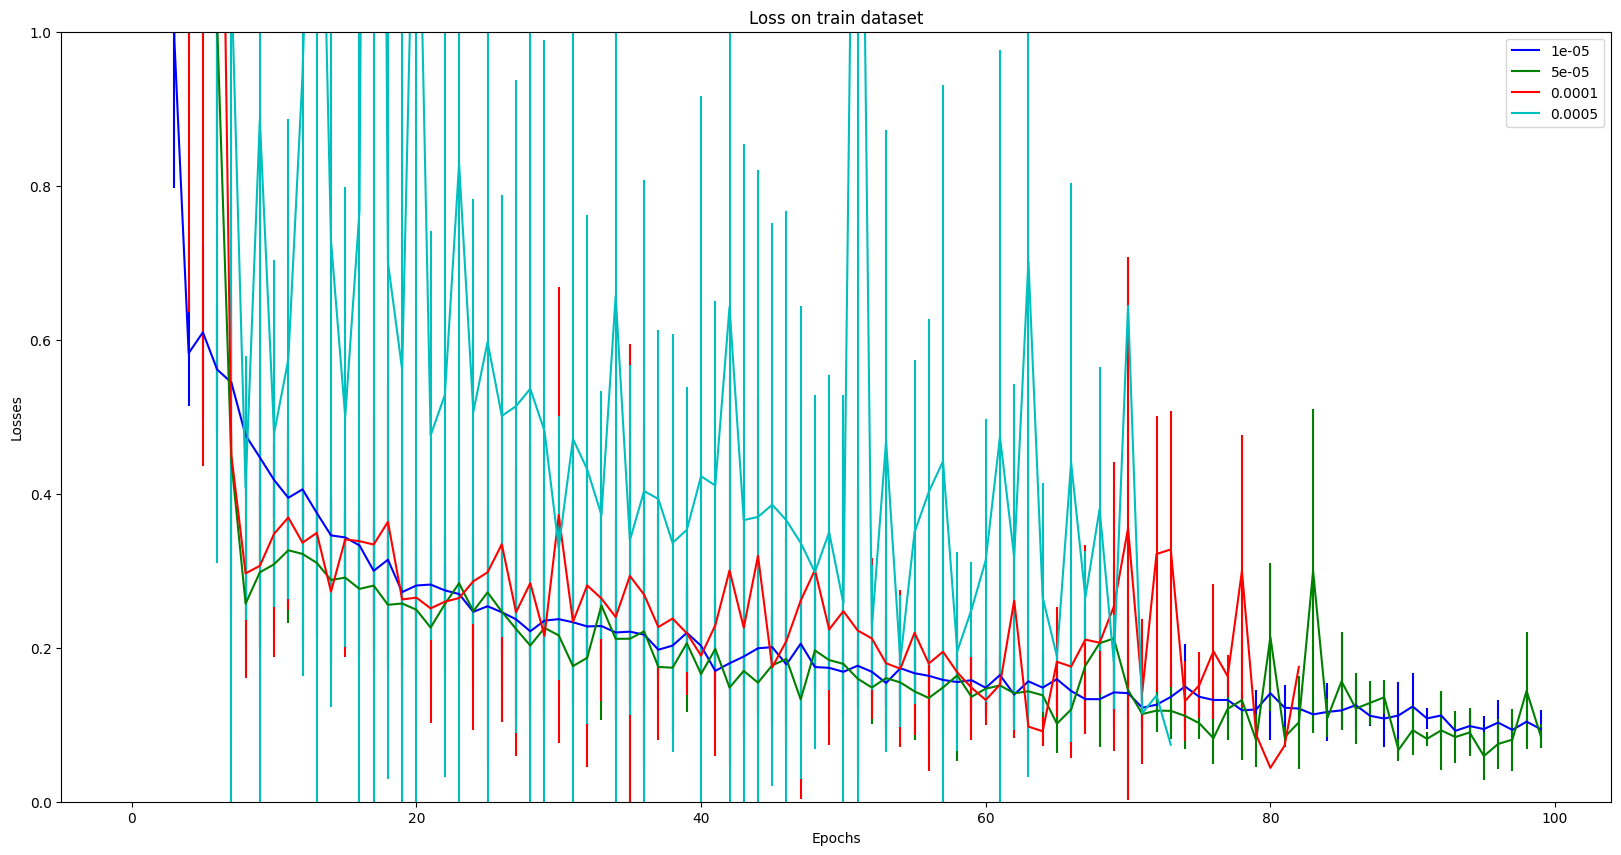

In [27]:
compare_params("LR2","lr",curve_to_plot="Train")

LR 5e-5 seems to have better performance, but not much difference between them.

batch_size: 128.0
Train Acc: 97.69 +- 0.73 % 
Valid Acc: 96.19 +- 0.46 % 
Test Acc: 89.99 +- 3.48 % 
Test Accuracy estimator: 89.99 +- 0.78 % . Median:90.19
batch_size: 256.0
Train Acc: 97.35 +- 0.78 % 
Valid Acc: 96.00 +- 0.40 % 
Test Acc: 91.00 +- 3.30 % 
Test Accuracy estimator: 91.00 +- 0.74 % . Median:91.58


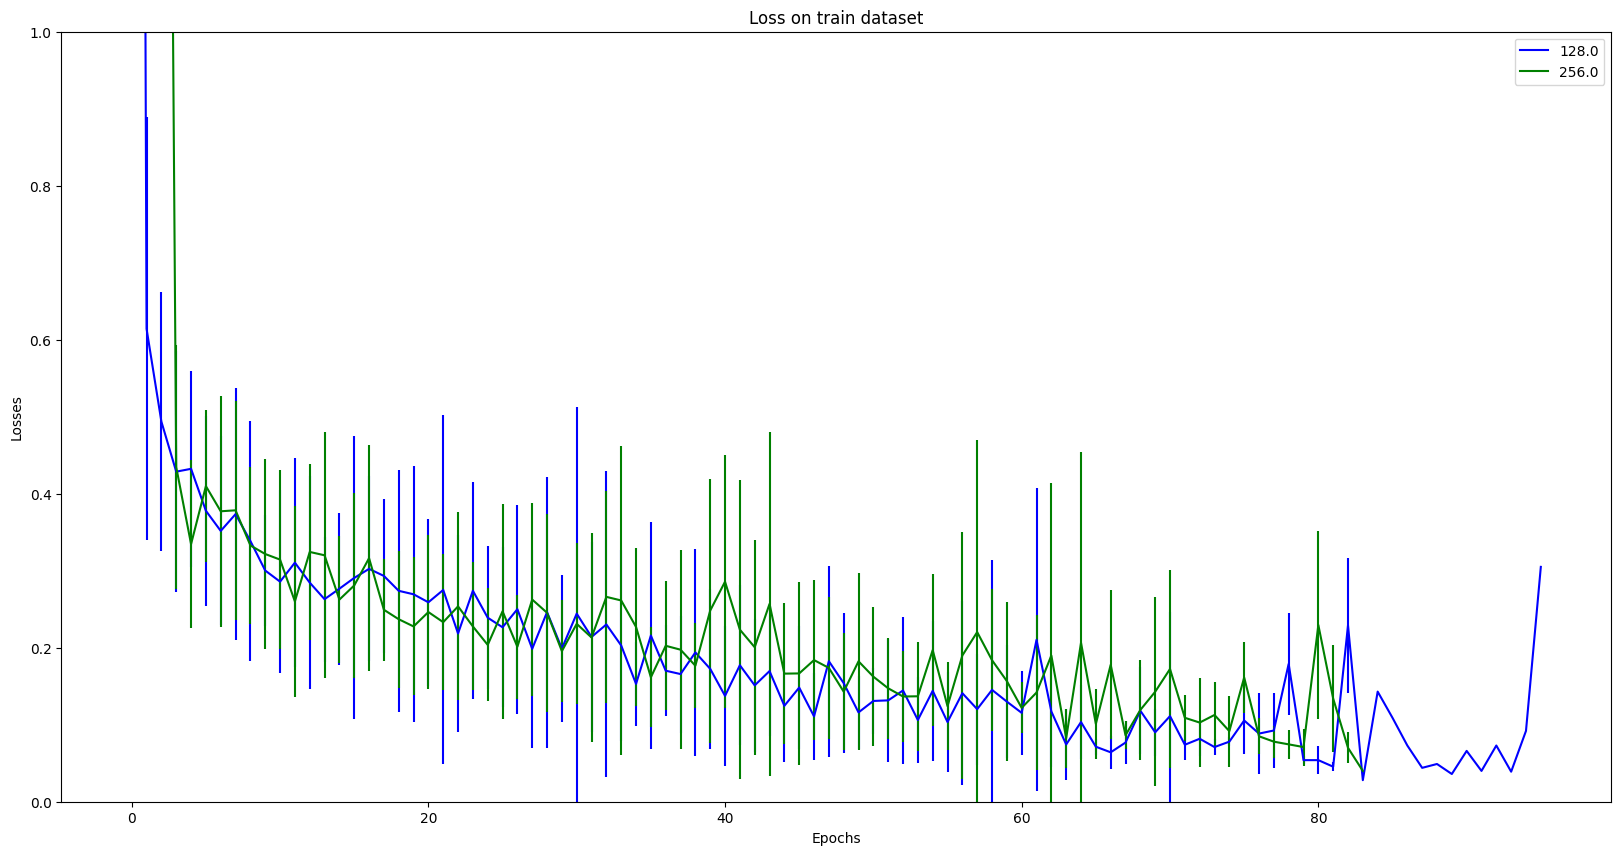

In [104]:
compare_params("BS2","batch_size",curve_to_plot="Train")

## Structure


dropout_end: 0.0
Train Acc: 97.35 +- 0.78 % 
Valid Acc: 96.00 +- 0.40 % 
Test Acc: 91.00 +- 3.30 % 
Test Accuracy estimator: 91.00 +- 0.74 % . Median:91.58
dropout_end: 0.4
Train Acc: 97.40 +- 0.72 % 
Valid Acc: 96.14 +- 0.37 % 
Test Acc: 90.25 +- 3.39 % 
Test Accuracy estimator: 90.25 +- 0.76 % . Median:90.22


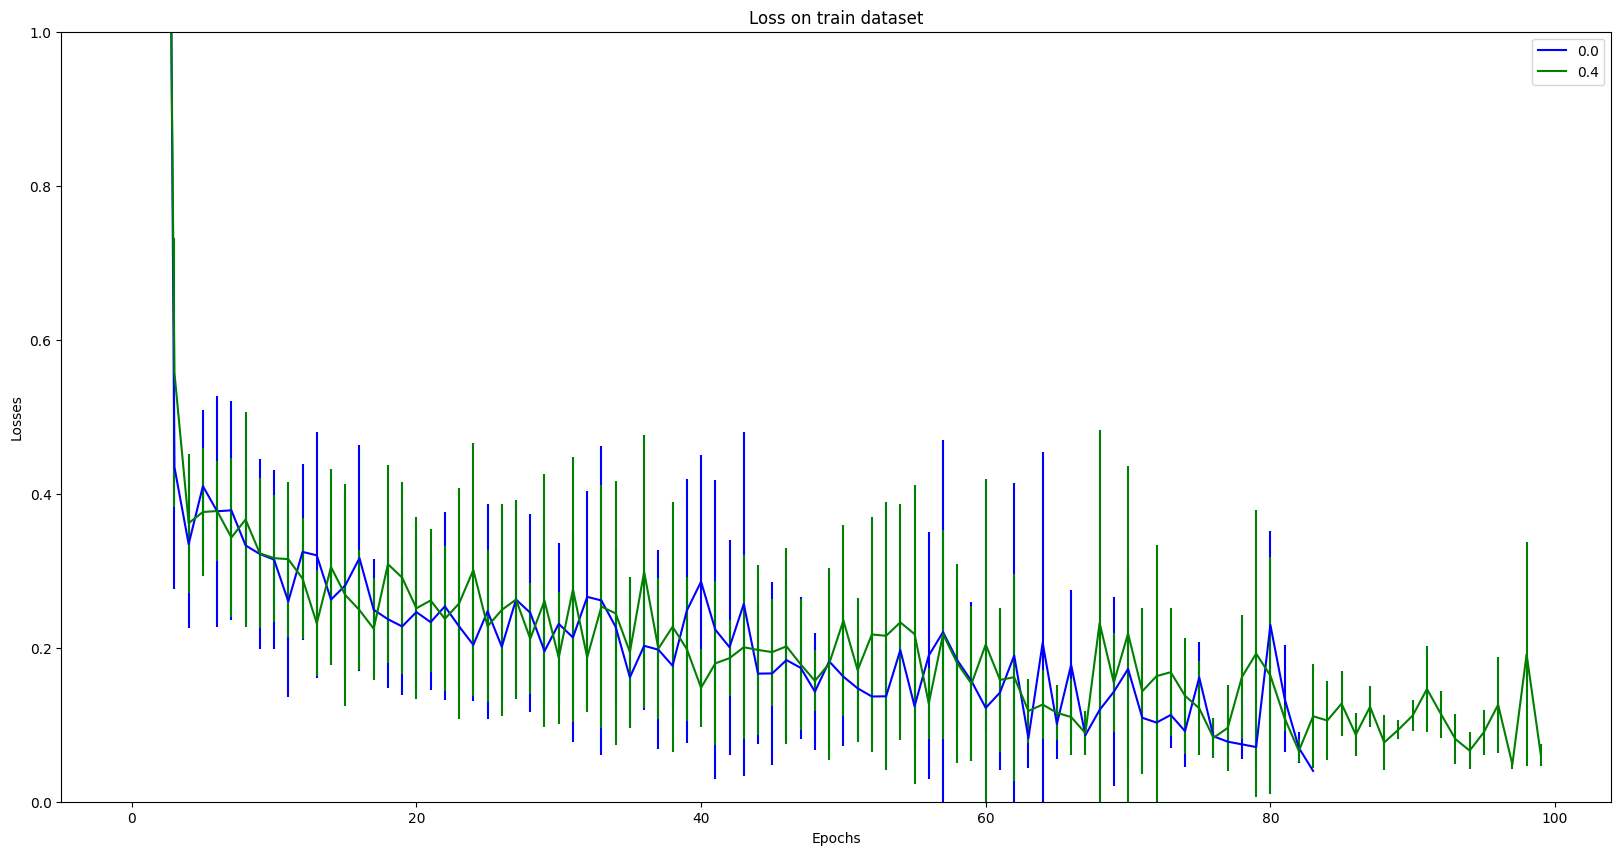

In [24]:
compare_params("DropoutEnd","dropout_end",curve_to_plot="Train",add_base_param="20231027_14-53-32_BS2.csv")

Dropout at the end doesnt seem to change much on the performance neither generalization.

dropout_blocks: 0.0
Train Acc: 97.35 +- 0.78 % 
Valid Acc: 96.00 +- 0.40 % 
Test Acc: 91.00 +- 3.30 % 
Test Accuracy estimator: 91.00 +- 0.74 % . Median:91.58
dropout_blocks: 0.1
Train Acc: 97.38 +- 0.67 % 
Valid Acc: 96.16 +- 0.43 % 
Test Acc: 92.20 +- 2.33 % 
Test Accuracy estimator: 92.20 +- 0.52 % . Median:92.69
dropout_blocks: 0.25
Train Acc: 97.33 +- 0.71 % 
Valid Acc: 96.29 +- 0.52 % 
Test Acc: 90.40 +- 3.44 % 
Test Accuracy estimator: 90.40 +- 0.77 % . Median:92.17


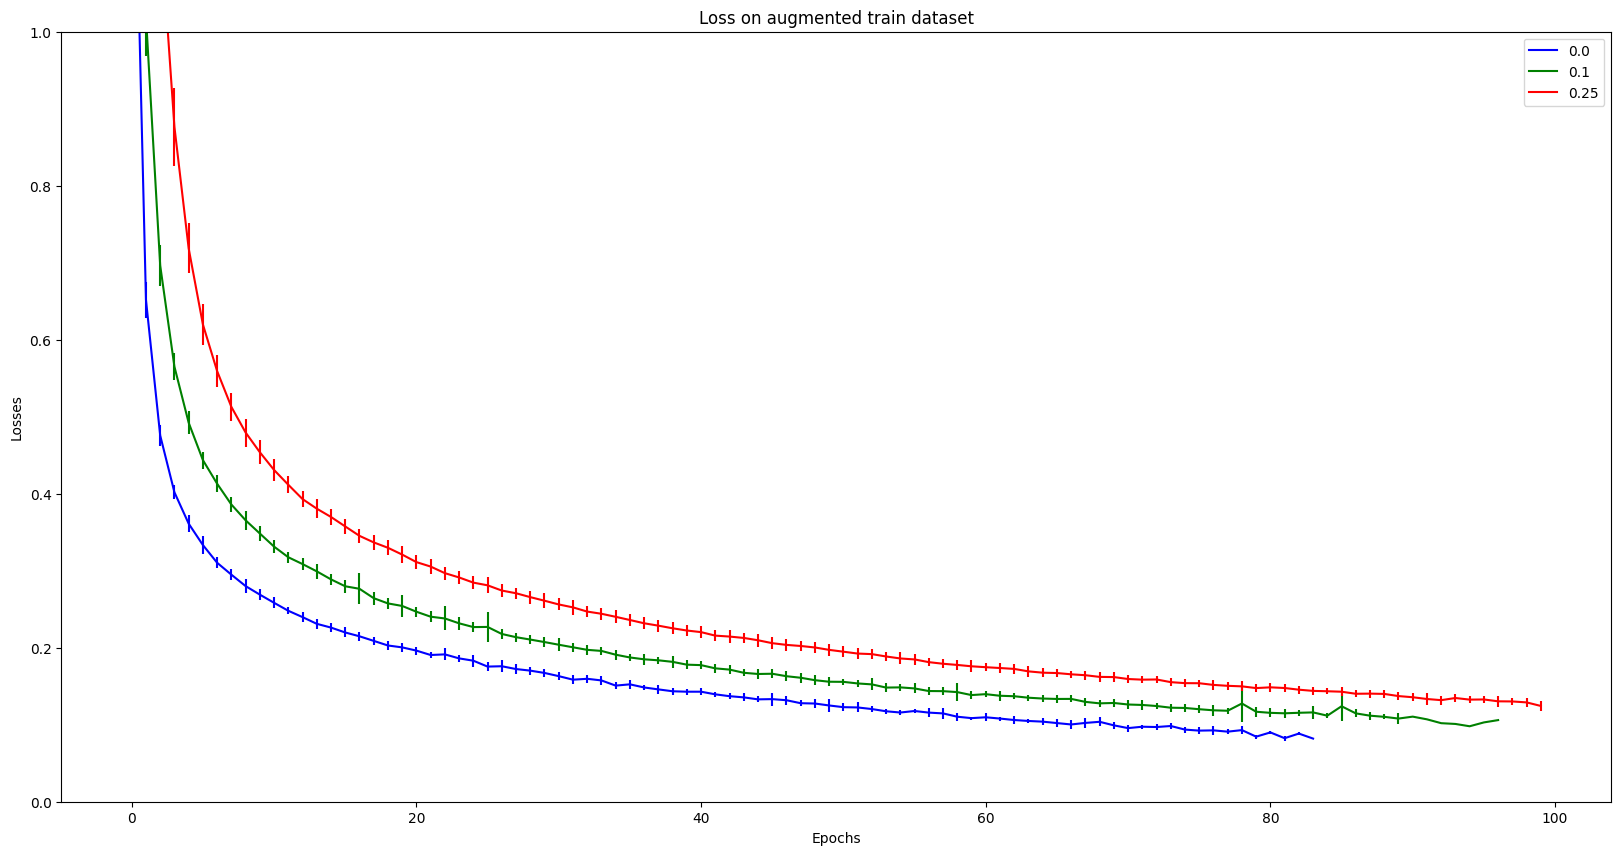

In [26]:
compare_params("DropoutBlock","dropout_blocks",curve_to_plot="AugTrain",add_base_param="20231027_14-53-32_BS2.csv")

dropout_end: 0.0
Train Acc: 97.38 +- 0.67 % 
Valid Acc: 96.16 +- 0.43 % 
Test Acc: 92.20 +- 2.33 % 
Test Accuracy estimator: 92.20 +- 0.52 % . Median:92.69
dropout_end: 0.2
Train Acc: 97.86 +- 0.46 % 
Valid Acc: 96.68 +- 0.38 % 
Test Acc: 90.52 +- 3.66 % 
Test Accuracy estimator: 90.52 +- 0.82 % . Median:90.74
dropout_end: 0.4
Train Acc: 97.68 +- 0.46 % 
Valid Acc: 96.59 +- 0.38 % 
Test Acc: 91.17 +- 3.52 % 
Test Accuracy estimator: 91.17 +- 0.79 % . Median:91.77


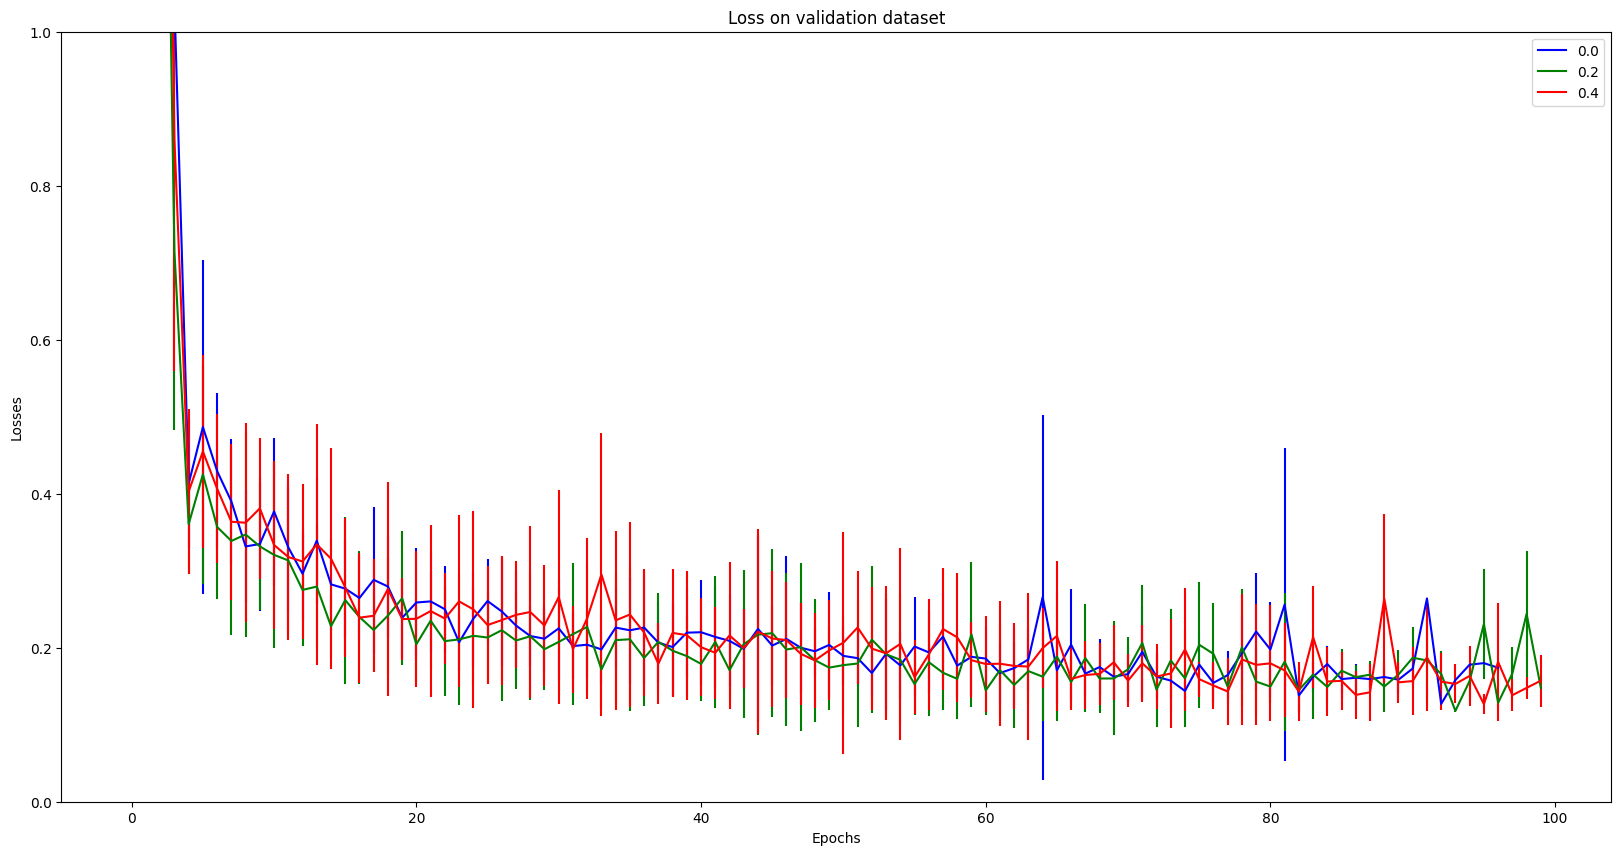

In [37]:
compare_params("Dense+Less layers","dropout_end",curve_to_plot="Valid",add_base_param="20231101_14-58-46_DropoutBlock.csv")

Dropout within the blocks is inspired by the architecture of Quipu, and seems like validation loss curve looks smaller, and at the same time the training curve seems that the learning rate is more adequated.

dense_1: 0.0
Train Acc: 97.38 +- 0.67 % 
Valid Acc: 96.16 +- 0.43 % 
Test Acc: 92.20 +- 2.33 % 
Test Accuracy estimator: 92.20 +- 0.52 % . Median:92.69
dense_1: 512.0
Train Acc: 97.97 +- 0.50 % 
Valid Acc: 96.52 +- 0.30 % 
Test Acc: 91.21 +- 2.66 % 
Test Accuracy estimator: 91.21 +- 0.59 % . Median:92.16


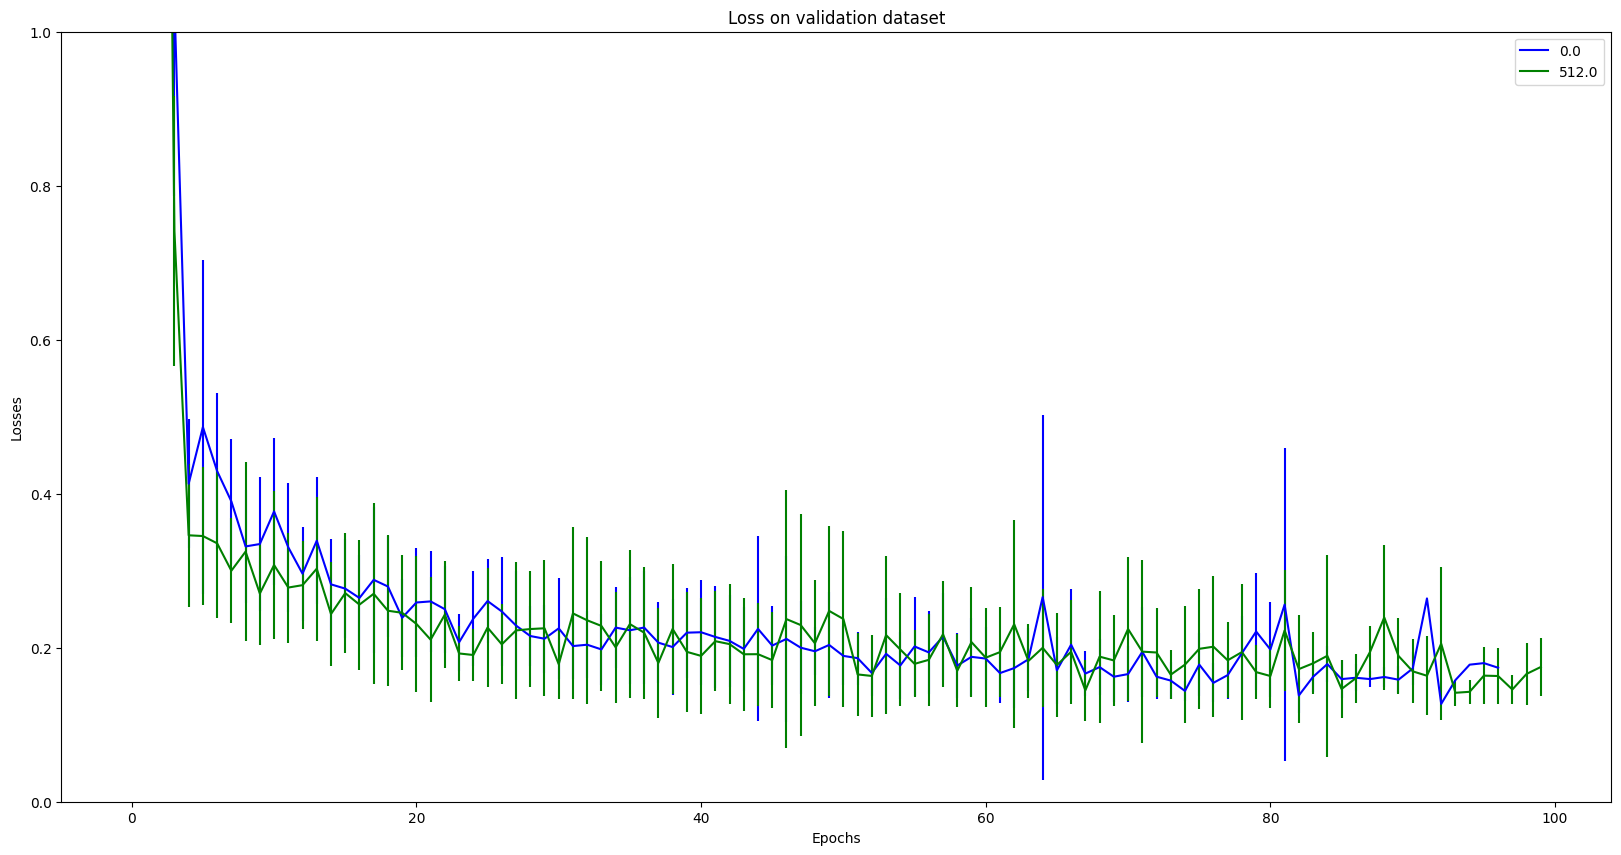

In [42]:
compare_params("Dense","dense_1",curve_to_plot="Valid",add_base_param="20231101_14-58-46_DropoutBlock.csv")

dense_1: 0.0
Train Acc: 97.38 +- 0.67 % 
Valid Acc: 96.16 +- 0.43 % 
Test Acc: 92.20 +- 2.33 % 
Test Accuracy estimator: 92.20 +- 0.52 % . Median:92.69
dense_1: 1024.0
Train Acc: 97.61 +- 0.68 % 
Valid Acc: 96.56 +- 0.39 % 
Test Acc: 92.44 +- 2.58 % 
Test Accuracy estimator: 92.44 +- 0.58 % . Median:93.04


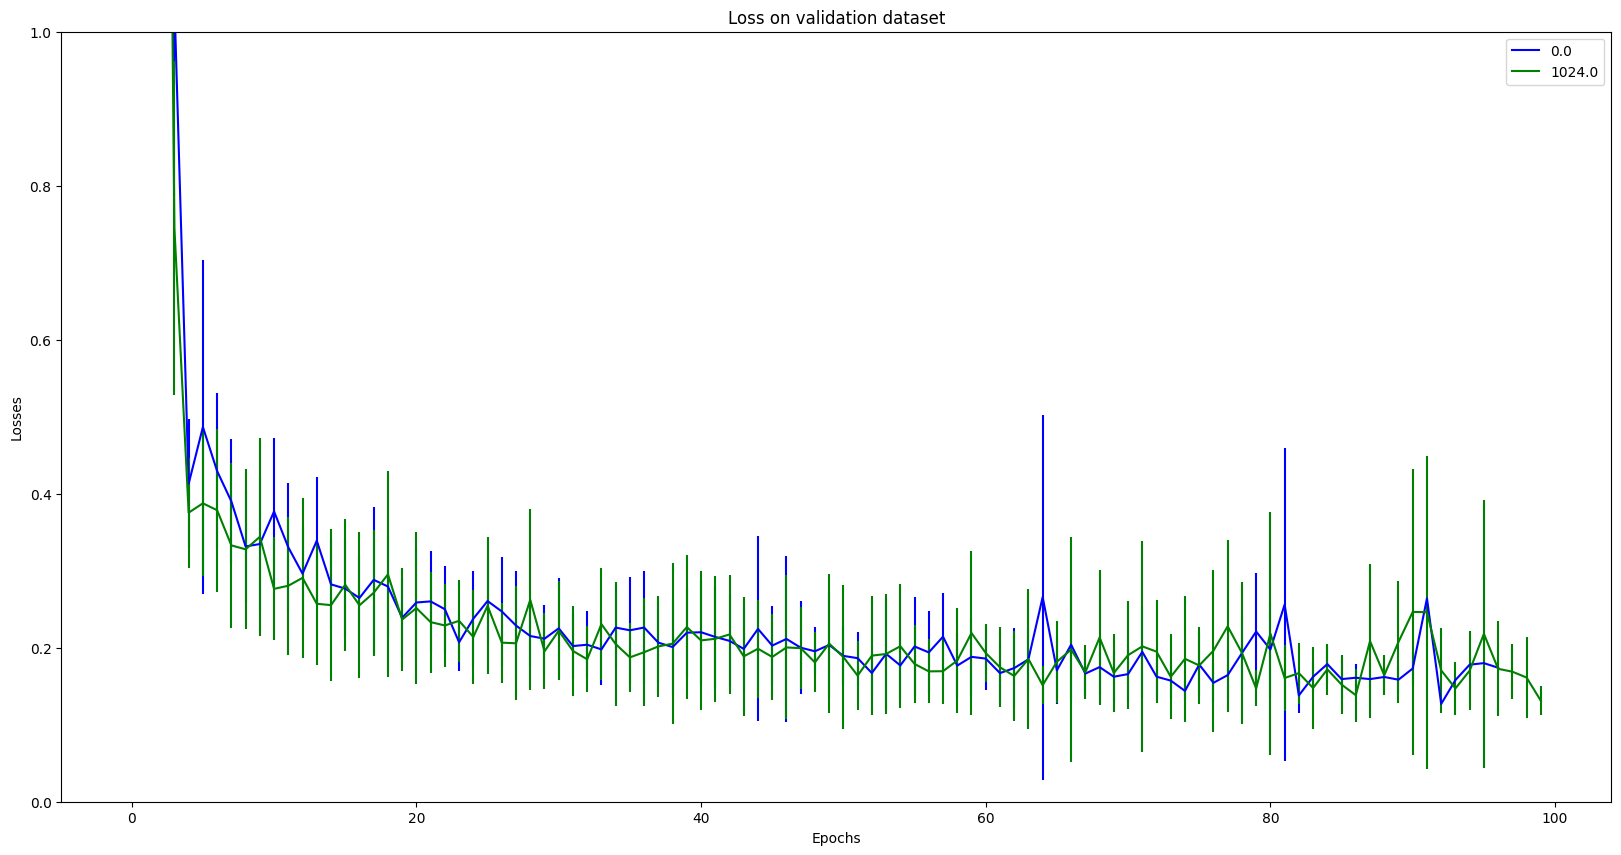

In [53]:
compare_params("DenseAndDropout","dense_1",curve_to_plot="Valid",add_base_param="20231101_14-58-46_DropoutBlock.csv")

activation: gelu

Train Acc: 97.79 +- 0.47 % 
Valid Acc: 96.55 +- 0.32 % 
Test Acc: 91.81 +- 3.58 % 
Test Accuracy estimator: 91.81 +- 0.80 % . Median:92.27
activation: relu

Train Acc: 97.61 +- 0.68 % 
Valid Acc: 96.56 +- 0.39 % 
Test Acc: 92.44 +- 2.58 % 
Test Accuracy estimator: 92.44 +- 0.58 % . Median:93.04
activation: swish

Train Acc: 97.89 +- 0.56 % 
Valid Acc: 96.53 +- 0.33 % 
Test Acc: 91.23 +- 2.95 % 
Test Accuracy estimator: 91.23 +- 0.66 % . Median:91.64


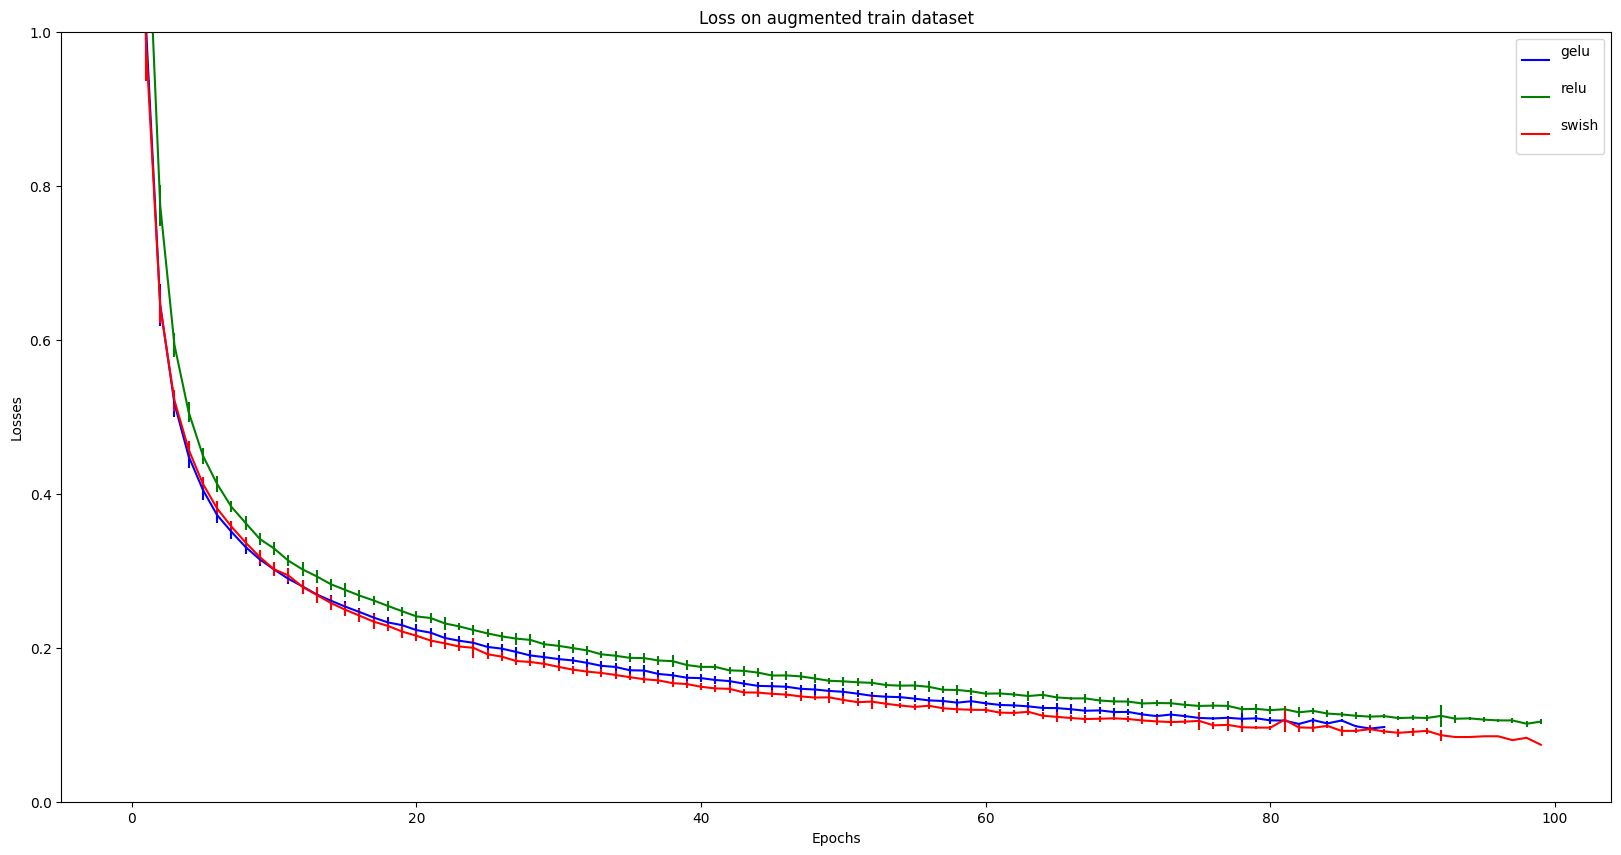

In [54]:
compare_params("Activation","activation",curve_to_plot="AugTrain",add_base_param="20231109_13-36-56_DenseAndDropout.csv")

## Other code backup

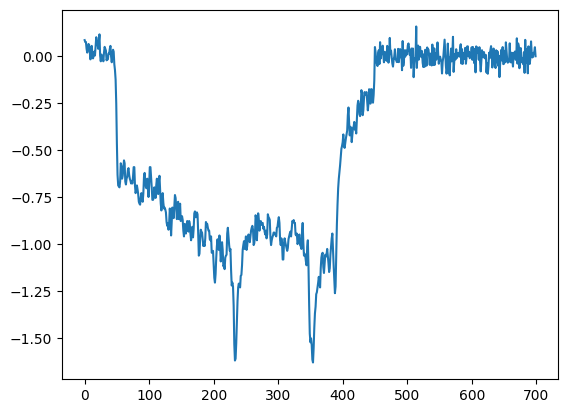

In [17]:
#np.argwhere(df_unfolded.iloc[0,2]<-0.25)[0,0]
np.argwhere(df_unfolded.iloc[0,2]<-0.5)[-1,0]
plt.plot(df_unfolded.iloc[0,2])

In [73]:
df_unfolded.iloc[0][2]

array([ 8.59865952e-02,  7.57338310e-02,  7.57337232e-02,  3.98493183e-02,
        1.93438985e-02,  3.47227747e-02,  6.54806357e-02,  6.03541997e-02,
        1.93434673e-02, -1.65409358e-02,  3.47222357e-02,  5.52274403e-02,
        1.42167081e-02, -1.14150392e-02,  3.96383653e-03,  2.44690405e-02,
        3.96362082e-03,  5.01004651e-02,  1.01363640e-01,  8.08582185e-02,
        6.54791259e-02,  3.98473773e-02,  8.08578948e-02,  1.16742085e-01,
        3.96275767e-03, -2.67953173e-02,  9.08886973e-03, -1.65428776e-02,
       -1.16400198e-03, -2.67957491e-02,  1.93410938e-02,  5.00989542e-02,
        3.98461900e-02,  2.95934259e-02, -2.16699612e-02, -1.14174136e-02,
       -1.65438494e-02,  1.42140099e-02,  1.42139019e-02,  3.98454339e-02,
        5.52243102e-02, -1.16540603e-03, -3.19234810e-02,  3.96070574e-03,
        3.47185655e-02,  2.44658014e-02, -4.21765687e-02, -7.29346425e-02,
       -1.24198025e-01, -2.52356308e-01, -4.67662117e-01, -6.31704635e-01,
       -6.88094316e-01, -

In [4]:
import os
import sys

path_common=os.path.dirname(os.path.abspath(''))+"/Common/";
sys.path.append(path_common) #Adds common path to import the python files


In [25]:
from DataAugmentator import DataAugmentator
from DataLoader import DataLoader
import tensorflow as tf

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[1], 'GPU')

dl=DataLoader();
X_train,X_valid,Y_train,Y_valid,X_test,Y_test=dl.get_datasets_numpy(repeat_classes=True);

In [28]:
da=DataAugmentator(opt_aug=False,noise_std=0);
da.stretch_std=0.1; 
da.magnitude_std=0.1;
da.stretch_prob=0; #This makes to augment all samples stretching them
da.brow_std=0; # we
da.noise_std=0.02; 
out=da.all_augments(X_train[:100,:])

In [24]:
np.std(X_train[:,600:])

0.04609879113238923

In [16]:
data_usage=0.5; #aprox half of the data actually contains information
points_per_sample=700; #Each trace has this points
n_samples_train=len(X_train);
useful_data=n_samples_train*points_per_sample*data_usage
print(useful_data)

15747200.0


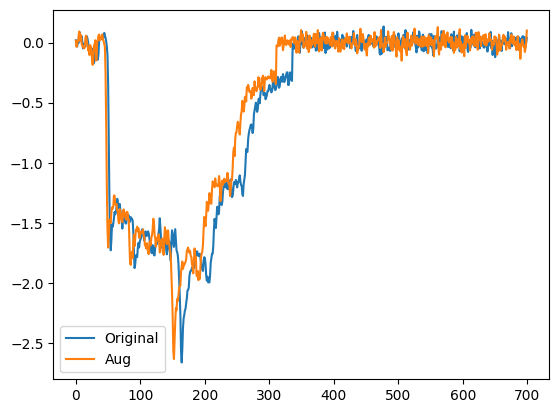

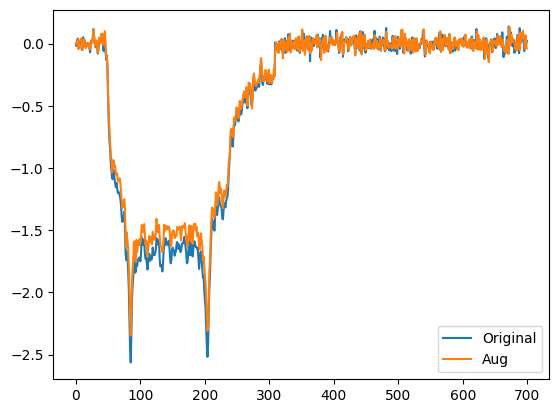

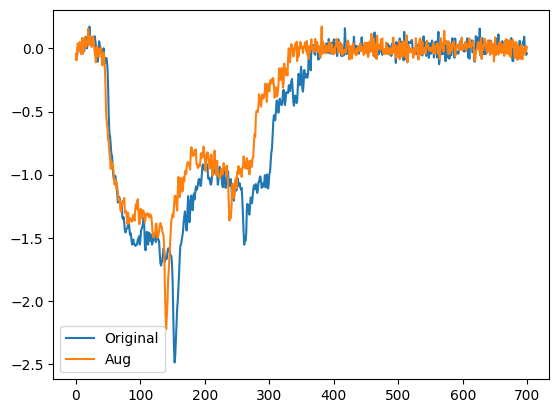

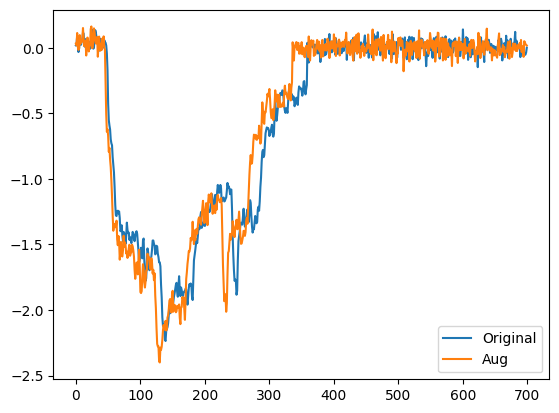

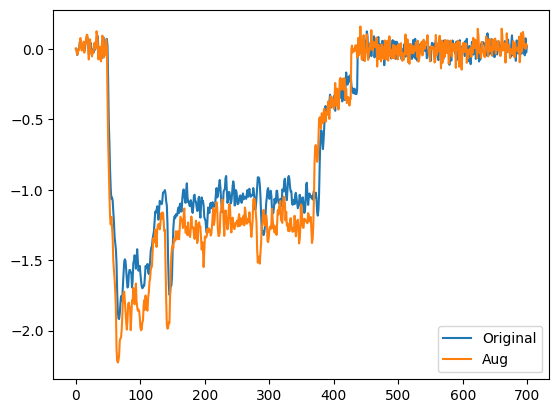

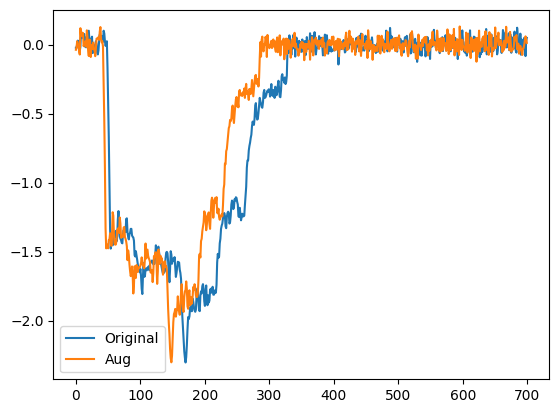

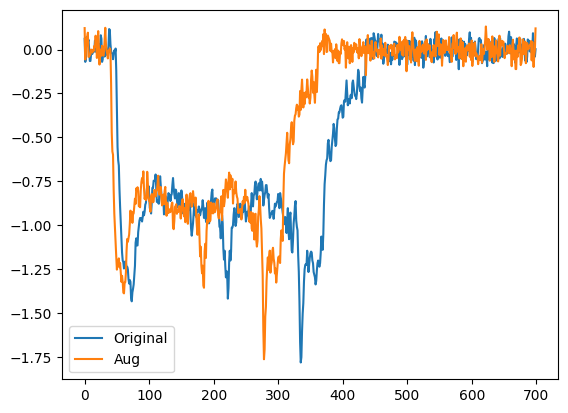

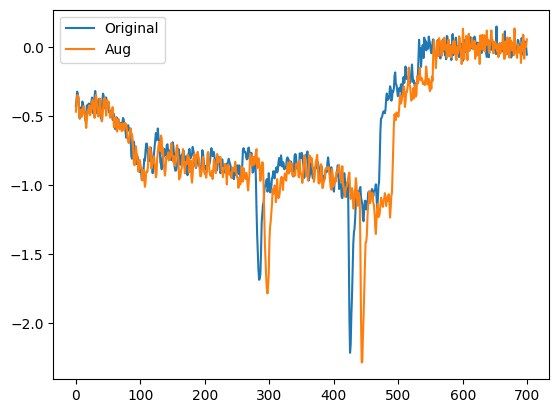

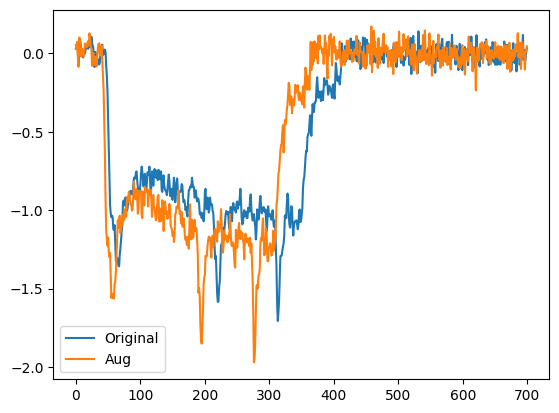

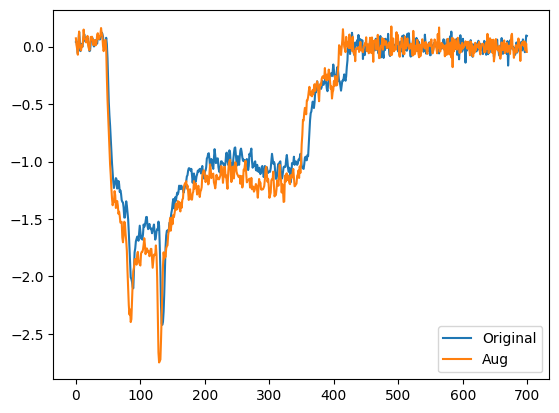

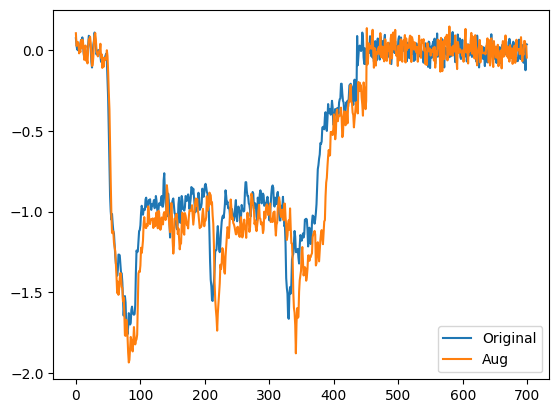

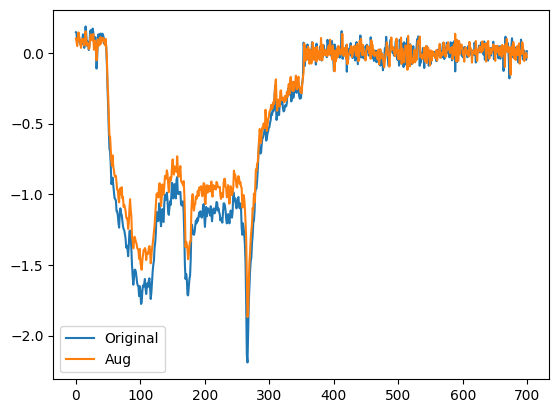

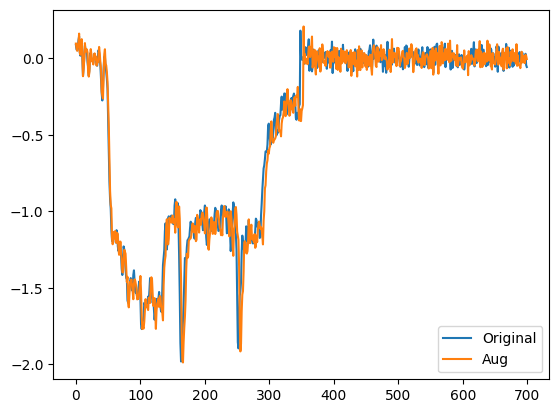

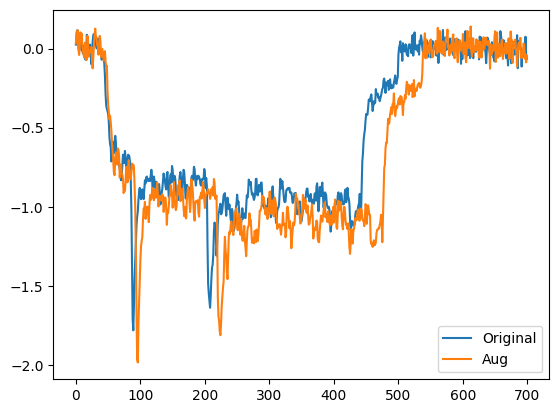

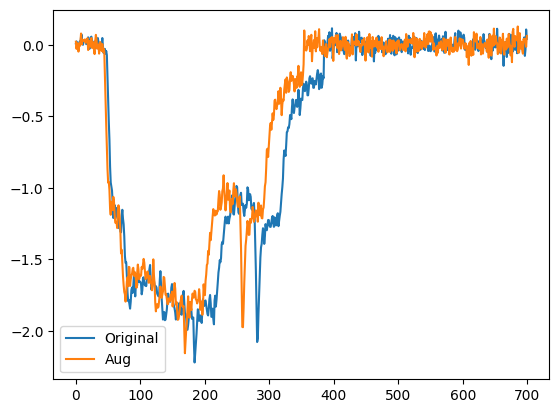

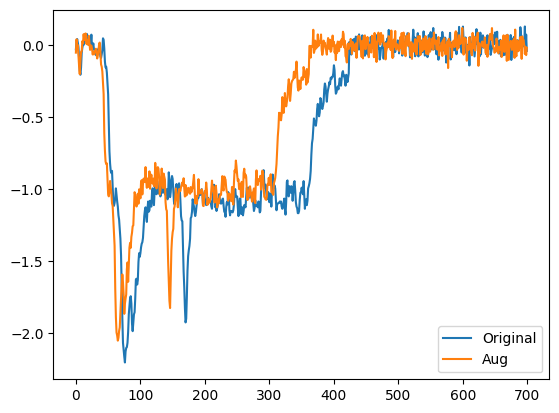

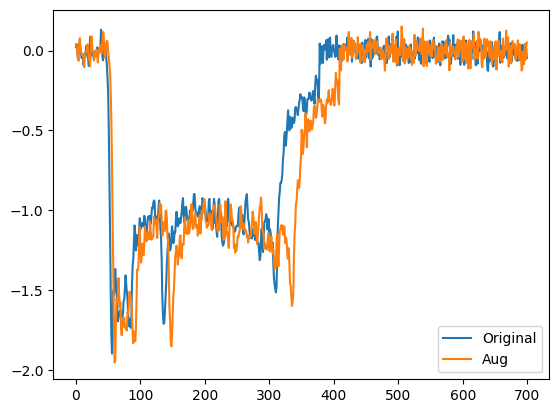

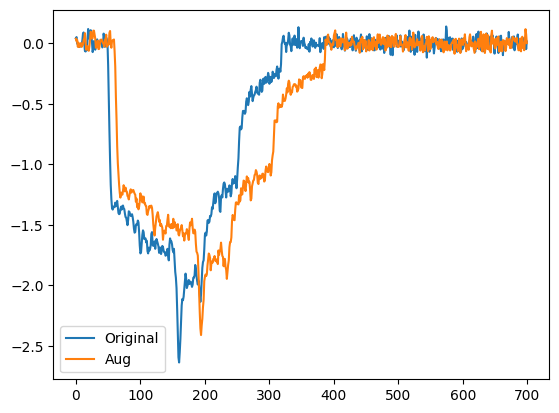

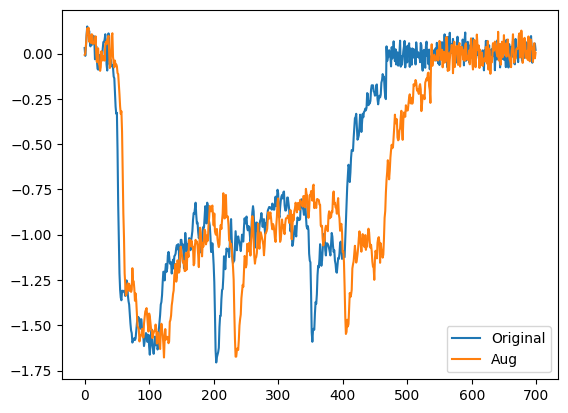

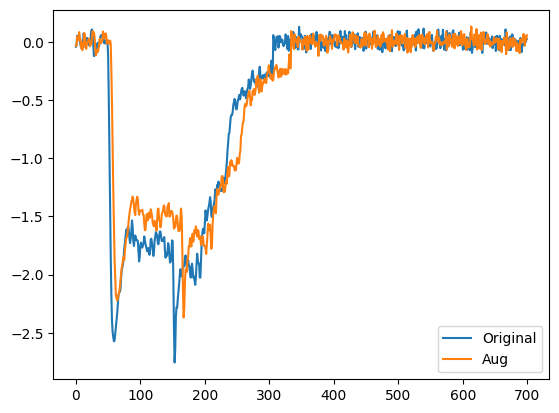

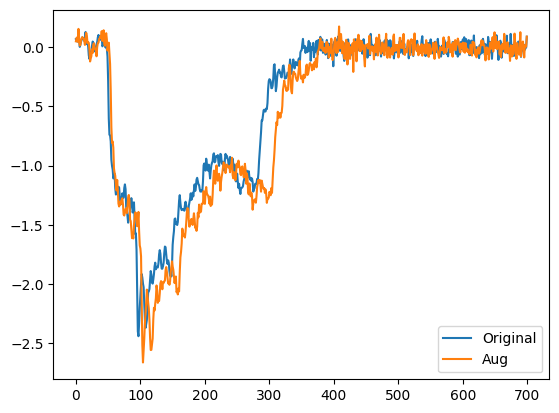

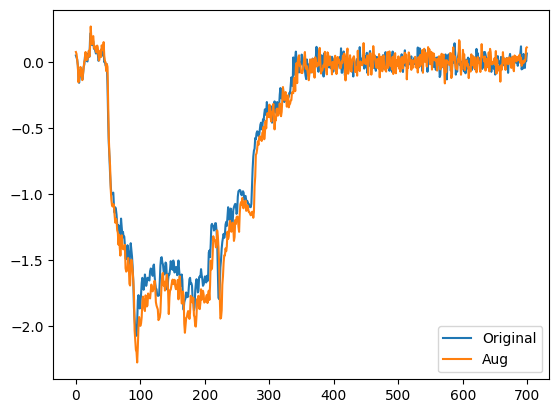

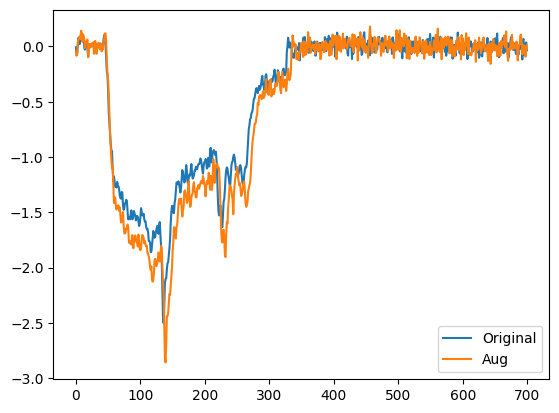

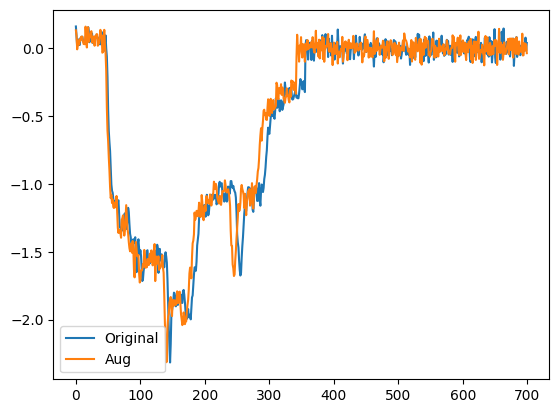

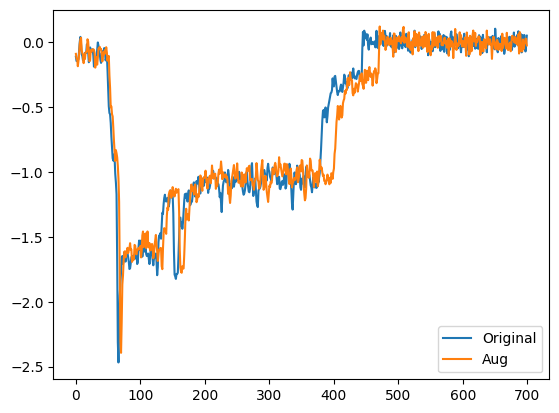

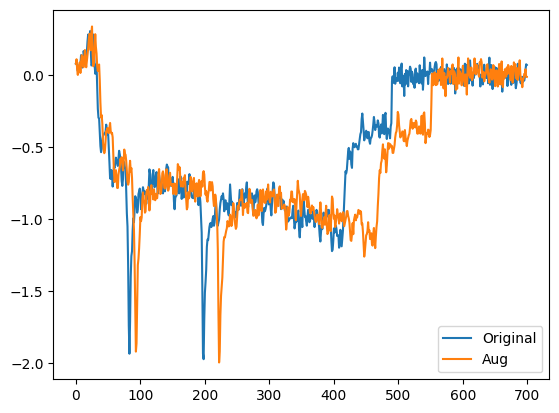

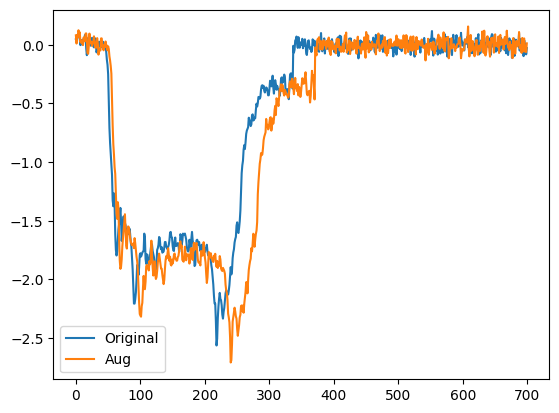

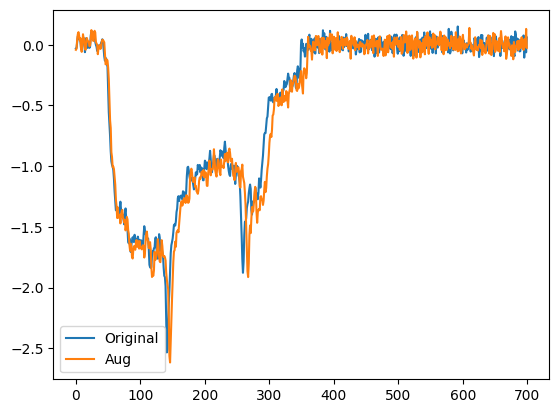

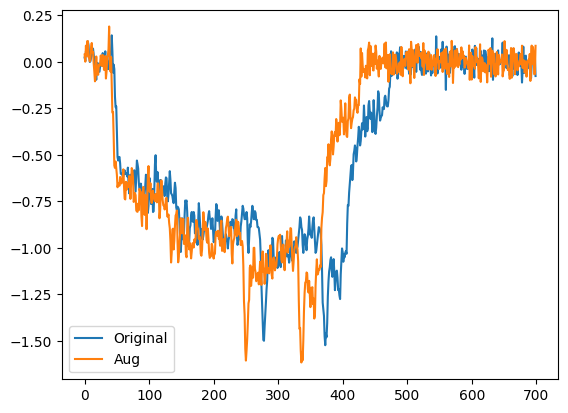

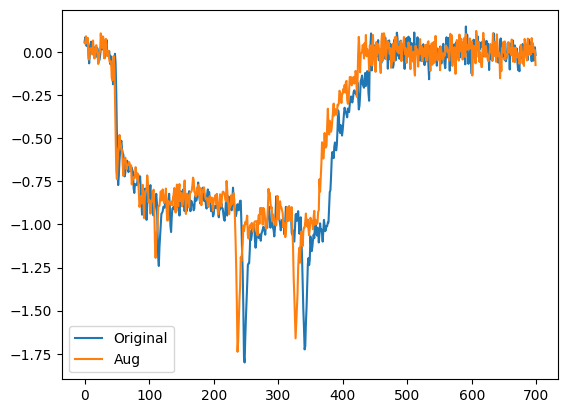

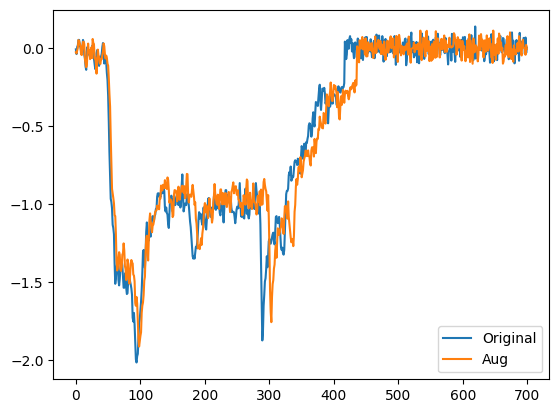

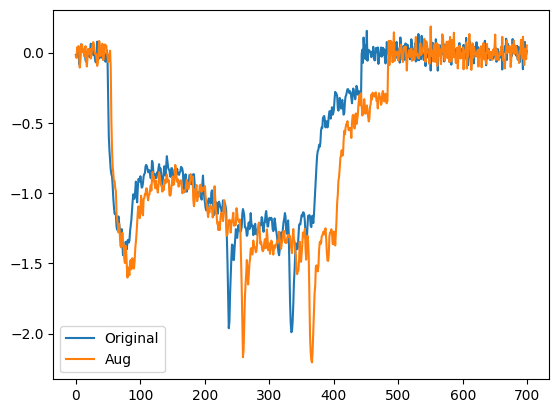

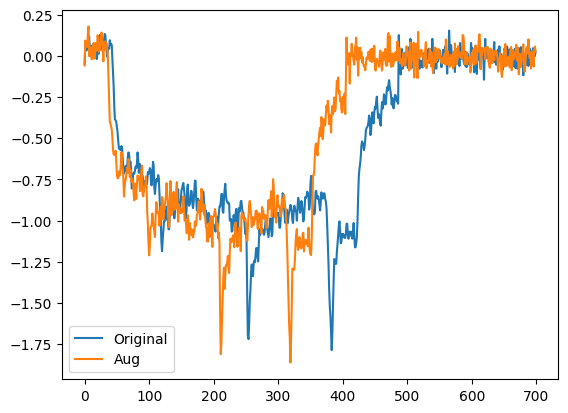

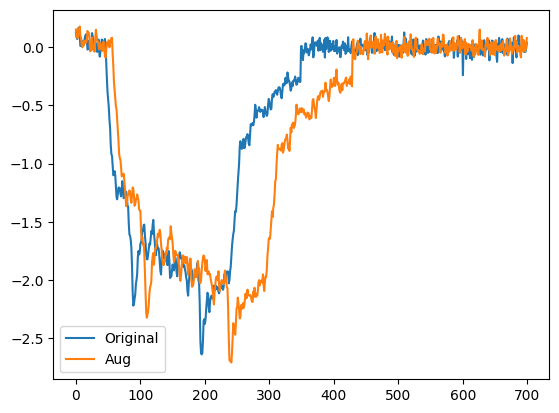

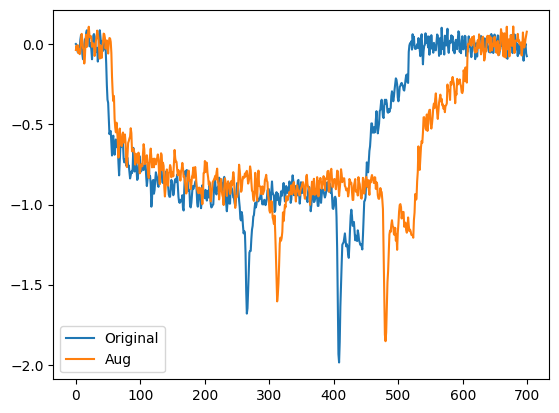

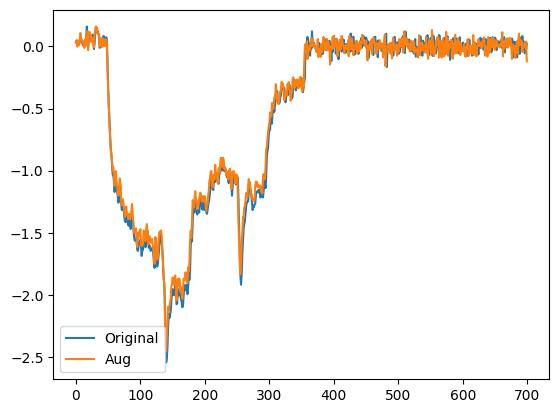

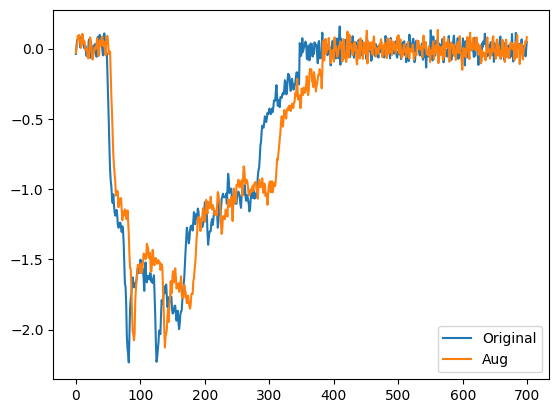

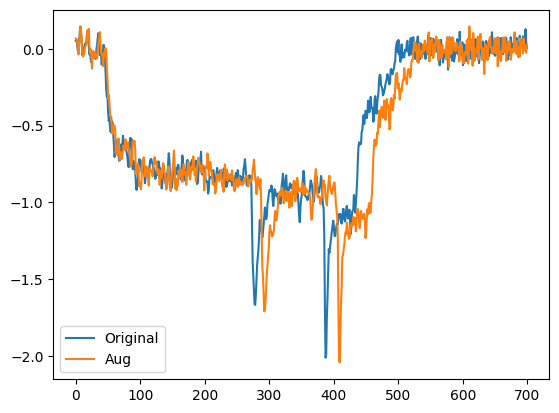

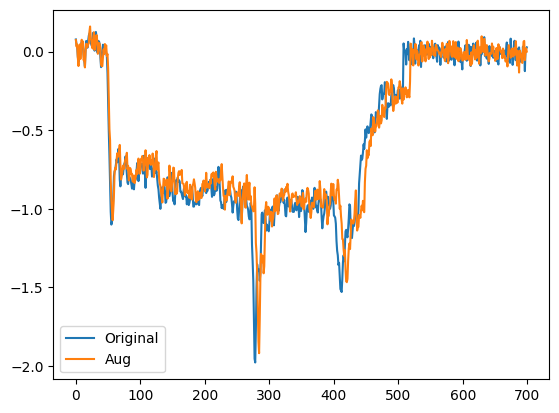

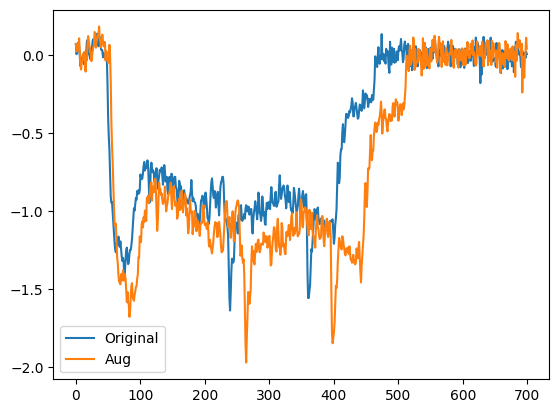

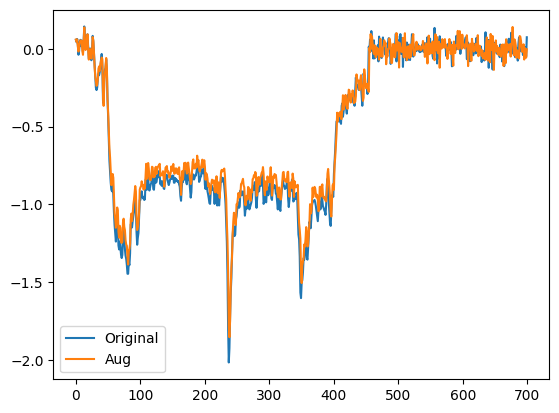

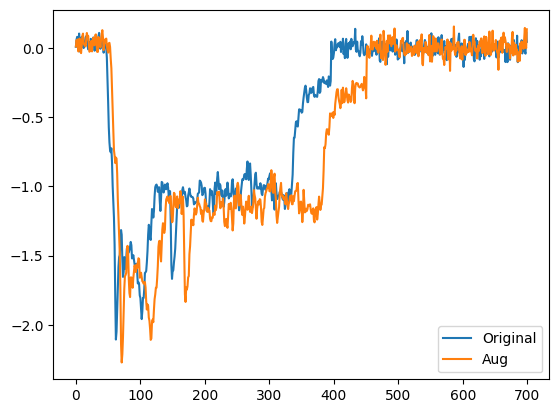

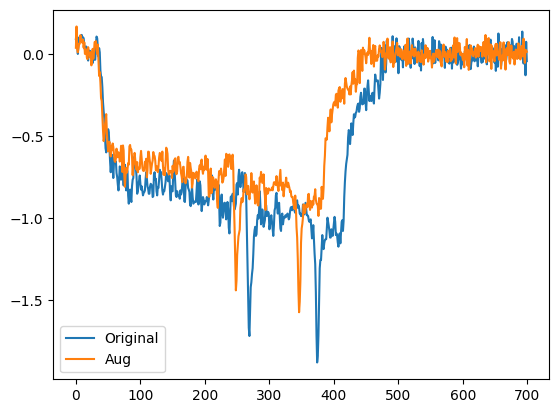

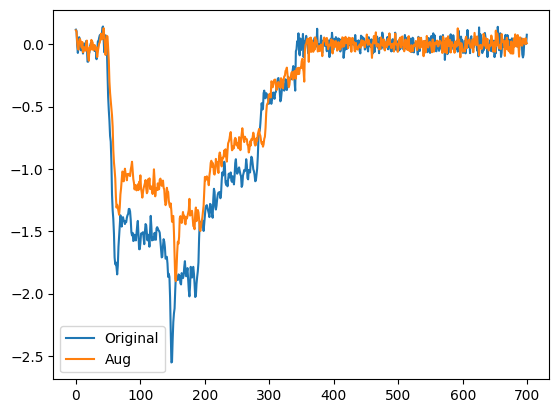

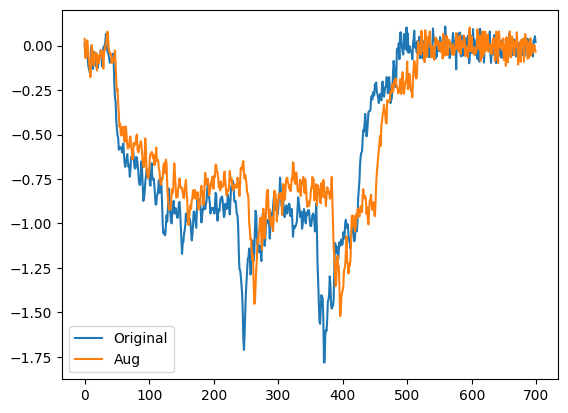

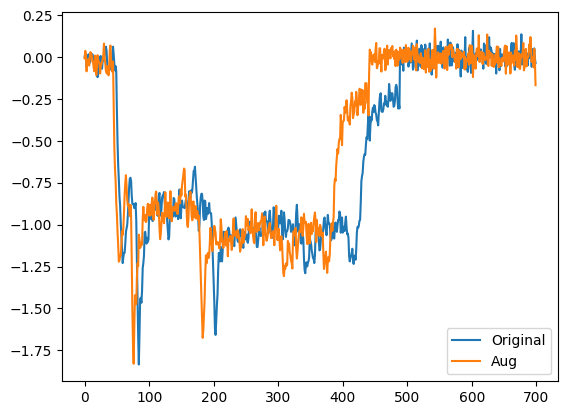

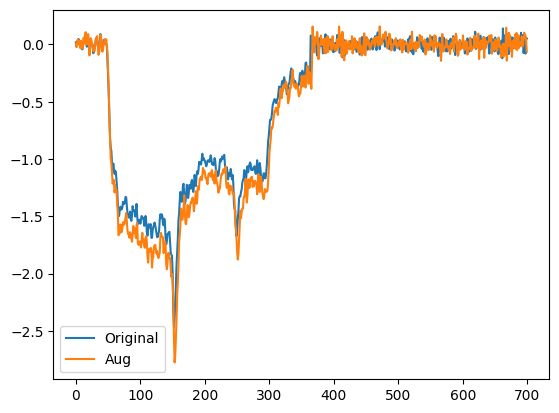

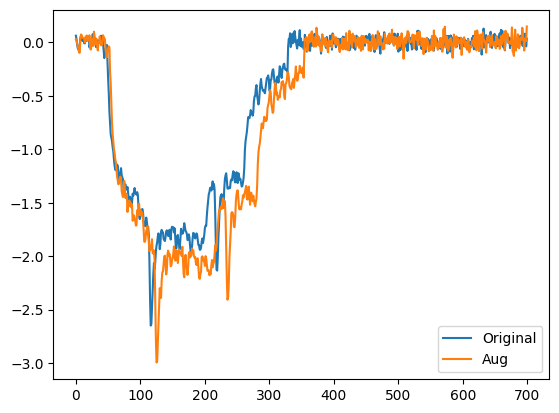

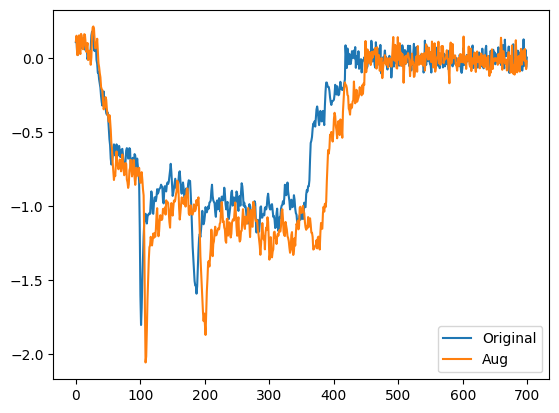

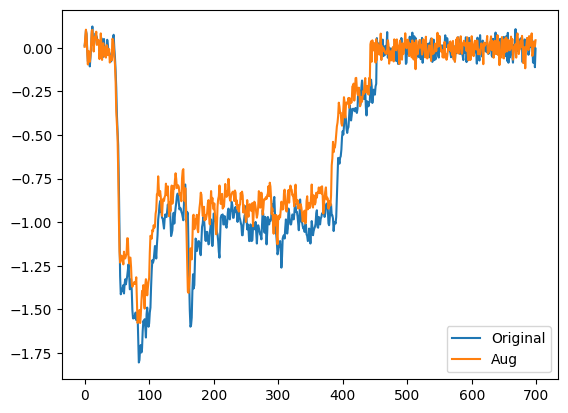

In [29]:
for i in range(50):
    plt.plot(X_train[i,:],label="Original")
    plt.plot(out[i,:],label="Aug")
    plt.legend()
    plt.show()

# Plots for presentations


In [5]:
from DatasetFuncs import load_unfolded_df,show_partition_nanopores #We load the unfolded dataframe
df_unfolded=load_unfolded_df()

Text(0.5, 1.0, 'Index 23442 - Barcode 111')

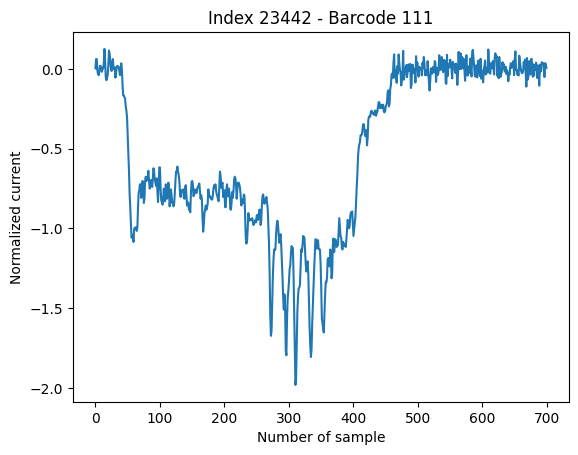

In [6]:
id_sample=23442;
trace_to_use_example=df_unfolded.loc[id_sample]["trace"];
barcode=df_unfolded.loc[id_sample]["barcode"];
plt.figure()
plt.plot(trace_to_use_example)
plt.xlabel("Number of sample")
plt.ylabel("Normalized current")
plt.title("Index "+str(id_sample) + " - Barcode "+barcode)

In [7]:
repetitions=np.tile(trace_to_use_example, (10, 1));
np.shape(repetitions)

(10, 700)

In [8]:
from DataAugmentator import DataAugmentator
da=DataAugmentator();
out,noise=da.brow_aug(repetitions,ret_noise=True);

Text(0.5, 1.0, 'Index 23442 - Barcode 111')

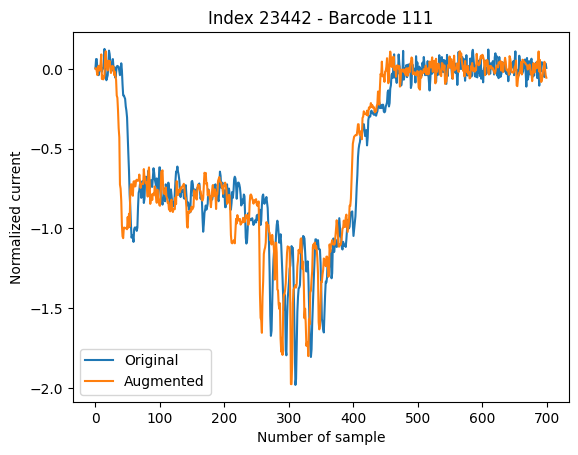

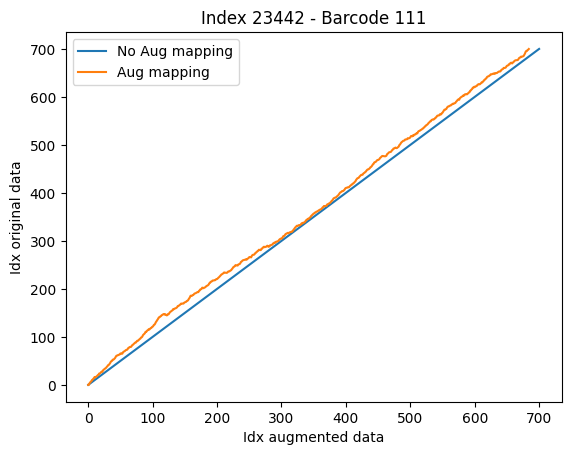

In [19]:
Aug_idx_to_compare=8
plt.figure()
plt.plot(trace_to_use_example,label="Original")
plt.plot(out[Aug_idx_to_compare,:],label="Augmented")
plt.xlabel("Number of sample")
plt.ylabel("Normalized current")
plt.title("Index "+str(id_sample) + " - Barcode "+barcode)
plt.legend();
plt.figure()
plt.plot([0, 700], [0,700],label="No Aug mapping")
browAugMap=[0]
for i in range(700):
    new_entry=1+browAugMap[i]+noise[Aug_idx_to_compare,i];
    if new_entry>700:
        break;
    else:
        browAugMap.append(new_entry)
plt.plot(browAugMap,label="Aug mapping")
plt.xlabel("Idx augmented data")
plt.ylabel("Idx original data")
plt.legend();
plt.title("Index "+str(id_sample) + " - Barcode "+barcode)

In [10]:
np.shape(noise)

(10, 700)